# Classification: Predict country based on part of speech tagging
### Steps:
1. Form two options of ground truth
    1. Form ground truth
        - Run spaCy over the training and validation data\
            Universal POS tags: 21 tag (https://universaldependencies.org/docs/u/pos/)
        - Problem: a lot of keywords were missed
    2. Form dictionary with covid and medical data
        - Get POS labled medical data (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.459.728&rep=rep1&type=pdf)
        - Make dictionary out of it
        - Form structures for POS tagging algorithm
            - Form train data: word\tpos\n
            - Form dictionary: every word to lowercase and occurs more than 2 times in training corpus
            - Form transition dictionary, emission dictionary, tags count and states (tags)
            - Form matrices of transition and emission (A and B)
        - Apply POS algorithm
            - For prediction: Take test corpus and form best probabilities and best paths matrices
            - Out of best paths take the prediction of pos tags
        - Evaluate the model: 85.3%
    3. Label COVID terms as NOUN
        https://www.tmc.edu/news/2020/05/covid-19-crisis-catalog-a-glossary-of-terms/

2. Choose ground truth
    1. Form file with ground truth taken from spaCy and from medical POS algorithm prediction
    2. Form set of COVID and modical words
        - From medical dictionary choose a number of the important ones (K_means)
        - Covid words list
    3. Define if the word from corpus related (cosine distance) to medical data, if so then apply medical POS alg. prediction; if it is realted to COVID words, then set NOUN as a ground truth, otherwise use spaCy.
    
3. Take 4 countries
    1. Form ground truth for each country article
    2. Create A nad B out of train data
    3. Create A nad B out of valid data
    4. Find dist between vectors of transition matrix
    5. Classify

In [10]:
import sys
sys.path.insert(1, '../')
import os
import re
import pandas as pd
import numpy as np
import json
import pickle
from main.helpers.predition_initialization import get_prep
from main.helpers.transition_emission import create_dictionaries
from main.helpers.print_examples import print_data_example, print_emission, \
print_transition, print_examples_of_prediction
from main.helpers.init import initialize
from main.helpers.viterbi import viterbi_forward, viterbi_backward

### Above we've formed the biggest dataset we could have formed

In [31]:
# df_ready.to_csv('./data/paper_country_the_biggest.csv', index=False)

In [6]:
df = pd.read_csv('./data/paper_country_the_biggest.csv')

In [8]:
countries_list = ['USA', 'China', 'Germany', 'Italy']

for c in countries_list:
    print(f'Print in smaller file for {c} there is {df[df.country == c].shape}')


Print in smaller file for USA there is (1650, 11)
Print in smaller file for China there is (1650, 11)
Print in smaller file for Germany there is (896, 11)
Print in smaller file for Italy there is (1631, 11)


In [9]:
df.head()

cord_uid                source_x  \
0  stsvjqhu  Elsevier; Medline; PMC   
1  3sl5u35h  Elsevier; Medline; PMC   
2  6dq8xx7c  Elsevier; Medline; PMC   
3  g3k1lpvd                     PMC   
4  gx6qy28p  Elsevier; Medline; PMC   

                                               title publish_time  \
0  In the search of potential epitopes for Wuhan ...   2020-04-23   
1  Letter to the Editor on “Bonafè M, Prattichizz...   2020-06-04   
2  Recent progress and challenges in drug develop...   2020-04-19   
3  Estimating Characteristic Sets for RDF Dataset...   2020-05-07   
4  An Outlook on the Global Development of Renewa...   2020-06-01   

                                             authors  \
0                   Santoni, Daniele; Vergni, Davide   
1  Quiros-Roldan, Eugenia; Biasiotto, Giorgio; Za...   
2     El-Aziz, Tarek Mohamed Abd; Stockand, James D.   
3                      Heling, Lars; Acosta, Maribel   
4                              Ehsan Hosseini, Seyed   

                                      pdf_json_files  \
0  document_parses/pdf_json/33e08133713a66c7df2c4...   
1  document_parses/pdf_json/5953e4cee71a72714880d...   
2  document_parses/pdf_json/0ddffb5065201f469bdbc...   
3  document_parses/pdf_json/5181d7bb2ce6a5a3ae079...   
4  document_parses/pdf_json/f81efa75ab4077e836052...   

                      journal  \
0           J Immunol Methods   
1  Cytokine Growth Factor Rev   
2           Infect Genet Evol   
3            The Semantic Web   
4          Energy Res Soc Sci   

                                                text  \
0  Coronaviruses belong to the family of Coronavi...   
1  This is a PDF file of an article that has unde...   
2  In the second week of December 2019, unknown v...   
3  The characteristics of an RDF dataset can be f...   
4  renewable and sustainable energy systems will ...   

                                         institution  \
0                 National Research Council of Italy   
1                              University of Brescia   
2  University of Texas Health Science Center at S...   
3            Karlsruhe Institute of Technology (KIT)   
4                           Arkansas Tech University   

                                          laboratory  country  
0                 National Research Council of Italy    Italy  
1                              University of Brescia    Italy  
2  University of Texas Health Science Center at S...      USA  
3            Karlsruhe Institute of Technology (KIT)  Germany  
4                           Arkansas Tech University      USA

### Set pathes

In [12]:
# TAGGED_DATA_PATH = './pos_tags_final_labels_'
PATH_TO_ORIGINAL_AB = './data/pos_matrices'
PATH_TO_COUNTRY_AB = './data/pos_matrices_country'
NEW_TAGGED_DATA = 'pos_tagged_data'
USA_PATH = os.path.join(PATH_TO_COUNTRY_AB, 'usa')
CHINA_PATH = os.path.join(PATH_TO_COUNTRY_AB, 'china')
ITALY_PATH = os.path.join(PATH_TO_COUNTRY_AB, 'italy')
GERMANY_PATH = os.path.join(PATH_TO_COUNTRY_AB, 'germany')
country_path_dict = {'usa': USA_PATH, 'china': CHINA_PATH, 'italy': ITALY_PATH, 'germany': GERMANY_PATH}
VOCAB_COVID = os.path.join(PATH_TO_ORIGINAL_AB, 'vocab_covid.txt')
TAG_COUNTS = os.path.join(PATH_TO_ORIGINAL_AB, 'tag_counts.json')

In [30]:
tag_counts = {'NOUN': 2994530,
         'PUNCT': 1597633,
         'ADV': 382880,
         'ADP': 1447502,
         'DET': 1104309,
         'ADJ': 1060602,
         'PROPN': 1117696,
         'CCONJ': 415113,
         'VERB': 1077277,
         'NUM': 518933,
         'AUX': 503869,
         'PRON': 187340,
         'SYM': 33734,
         'PART': 161295,
         'SCONJ': 136450,
         'X': 21511,
         'INTJ': 2262,
         'VDD': 183,
         'VDN': 38,
         'VDZ': 78,
         'VDB': 71,
         'SPACE': 11}

In [31]:
# Import vocab
f_vocab = open(VOCAB_COVID, 'r')
vocab = {el.replace('\n', ''): i for i, el in enumerate(f_vocab)}
f_vocab.close()

In [32]:
def one_country_text_list(df, country):
    return tuple(zip(df[df.country == country].cord_uid.values, df[df.country == country].text.values))


germany_text_list = one_country_text_list(df, 'Germany')
italy_text_list = one_country_text_list(df, 'Italy')
china_text_list = one_country_text_list(df, 'China')
usa_text_list = one_country_text_list(df, 'USA')

In [33]:
countries_dict = {'germany': germany_text_list, 'italy': italy_text_list, \
                  'china': china_text_list, 'usa': usa_text_list}

In [34]:
for c, val in countries_dict.items():
    print(f'{c}: {len(val)}')
    print('emaple of val[0][0]: ', val[0][0], 'val[0][1]: ', val[0][1][:10])

germany: 896
emaple of val[0][0]:  g3k1lpvd val[0][1]:  The charac
italy: 1631
emaple of val[0][0]:  stsvjqhu val[0][1]:  Coronaviru
china: 1650
emaple of val[0][0]:  57qa23om val[0][1]:  O steonecr
usa: 1650
emaple of val[0][0]:  6dq8xx7c val[0][1]:  In the sec


In [35]:
def custom_split(text):
    return list(filter(lambda x: not(x == '' or x == ' '), re.split(r'(\b[^\s]+\b)', text.strip())))

### Form prep for each country

In [36]:
# prepare test data for prediction
prep = {}
for key in countries_dict.keys():
    prep[key] = []
prep

{'germany': [], 'italy': [], 'china': [], 'usa': []}

In [37]:
# prep formation must be this way
# create prep dict for each country
prep = {}
for key in countries_dict.keys():
    prep[key] = []

for country_name in countries_dict.keys():
    for tuple_uid_text in countries_dict[country_name]:
        # for each article get its id and split the text by words
        uid, text = tuple_uid_text[0], tuple_uid_text[1]
        text_words = custom_split(text)

        orig, tmp_prep = get_prep(text_words, vocab)
        prep[country_name].append((uid, tmp_prep))
        print('Number of preps for country: ', len(prep[country_name]), \
              '; Len of the text prep: ', len(tmp_prep))

Number of preps for country:  1 ; Len of the text prep:  7096
Number of preps for country:  2 ; Len of the text prep:  1406
Number of preps for country:  3 ; Len of the text prep:  3299
Number of preps for country:  4 ; Len of the text prep:  3124
Number of preps for country:  5 ; Len of the text prep:  5510
Number of preps for country:  6 ; Len of the text prep:  15608
Number of preps for country:  7 ; Len of the text prep:  3408
Number of preps for country:  8 ; Len of the text prep:  3606
Number of preps for country:  9 ; Len of the text prep:  20179
Number of preps for country:  10 ; Len of the text prep:  3555
Number of preps for country:  11 ; Len of the text prep:  592
Number of preps for country:  12 ; Len of the text prep:  10095
Number of preps for country:  13 ; Len of the text prep:  4834
Number of preps for country:  14 ; Len of the text prep:  3736
Number of preps for country:  15 ; Len of the text prep:  9443
Number of preps for country:  16 ; Len of the text prep:  1130

Number of preps for country:  144 ; Len of the text prep:  8151
Number of preps for country:  145 ; Len of the text prep:  7612
Number of preps for country:  146 ; Len of the text prep:  3128
Number of preps for country:  147 ; Len of the text prep:  2437
Number of preps for country:  148 ; Len of the text prep:  891
Number of preps for country:  149 ; Len of the text prep:  9850
Number of preps for country:  150 ; Len of the text prep:  5605
Number of preps for country:  151 ; Len of the text prep:  5522
Number of preps for country:  152 ; Len of the text prep:  3948
Number of preps for country:  153 ; Len of the text prep:  815
Number of preps for country:  154 ; Len of the text prep:  5657
Number of preps for country:  155 ; Len of the text prep:  8842
Number of preps for country:  156 ; Len of the text prep:  1765
Number of preps for country:  157 ; Len of the text prep:  3765
Number of preps for country:  158 ; Len of the text prep:  2460
Number of preps for country:  159 ; Len of

Number of preps for country:  302 ; Len of the text prep:  10136
Number of preps for country:  303 ; Len of the text prep:  913
Number of preps for country:  304 ; Len of the text prep:  4112
Number of preps for country:  305 ; Len of the text prep:  4295
Number of preps for country:  306 ; Len of the text prep:  635
Number of preps for country:  307 ; Len of the text prep:  4472
Number of preps for country:  308 ; Len of the text prep:  4160
Number of preps for country:  309 ; Len of the text prep:  17354
Number of preps for country:  310 ; Len of the text prep:  1129
Number of preps for country:  311 ; Len of the text prep:  1501
Number of preps for country:  312 ; Len of the text prep:  9482
Number of preps for country:  313 ; Len of the text prep:  3457
Number of preps for country:  314 ; Len of the text prep:  1977
Number of preps for country:  315 ; Len of the text prep:  1157
Number of preps for country:  316 ; Len of the text prep:  5348
Number of preps for country:  317 ; Len 

Number of preps for country:  451 ; Len of the text prep:  6734
Number of preps for country:  452 ; Len of the text prep:  4314
Number of preps for country:  453 ; Len of the text prep:  547
Number of preps for country:  454 ; Len of the text prep:  4758
Number of preps for country:  455 ; Len of the text prep:  1664
Number of preps for country:  456 ; Len of the text prep:  2218
Number of preps for country:  457 ; Len of the text prep:  7141
Number of preps for country:  458 ; Len of the text prep:  3946
Number of preps for country:  459 ; Len of the text prep:  3113
Number of preps for country:  460 ; Len of the text prep:  2881
Number of preps for country:  461 ; Len of the text prep:  6467
Number of preps for country:  462 ; Len of the text prep:  1532
Number of preps for country:  463 ; Len of the text prep:  4568
Number of preps for country:  464 ; Len of the text prep:  2564
Number of preps for country:  465 ; Len of the text prep:  862
Number of preps for country:  466 ; Len of

Number of preps for country:  604 ; Len of the text prep:  4852
Number of preps for country:  605 ; Len of the text prep:  8007
Number of preps for country:  606 ; Len of the text prep:  8144
Number of preps for country:  607 ; Len of the text prep:  5179
Number of preps for country:  608 ; Len of the text prep:  1434
Number of preps for country:  609 ; Len of the text prep:  1629
Number of preps for country:  610 ; Len of the text prep:  5840
Number of preps for country:  611 ; Len of the text prep:  2412
Number of preps for country:  612 ; Len of the text prep:  8299
Number of preps for country:  613 ; Len of the text prep:  9547
Number of preps for country:  614 ; Len of the text prep:  1333
Number of preps for country:  615 ; Len of the text prep:  931
Number of preps for country:  616 ; Len of the text prep:  1450
Number of preps for country:  617 ; Len of the text prep:  5546
Number of preps for country:  618 ; Len of the text prep:  3809
Number of preps for country:  619 ; Len o

Number of preps for country:  743 ; Len of the text prep:  1976
Number of preps for country:  744 ; Len of the text prep:  3848
Number of preps for country:  745 ; Len of the text prep:  2725
Number of preps for country:  746 ; Len of the text prep:  1991
Number of preps for country:  747 ; Len of the text prep:  642
Number of preps for country:  748 ; Len of the text prep:  2332
Number of preps for country:  749 ; Len of the text prep:  1183
Number of preps for country:  750 ; Len of the text prep:  7078
Number of preps for country:  751 ; Len of the text prep:  680
Number of preps for country:  752 ; Len of the text prep:  763
Number of preps for country:  753 ; Len of the text prep:  4478
Number of preps for country:  754 ; Len of the text prep:  3141
Number of preps for country:  755 ; Len of the text prep:  10422
Number of preps for country:  756 ; Len of the text prep:  5273
Number of preps for country:  757 ; Len of the text prep:  1549
Number of preps for country:  758 ; Len of

Number of preps for country:  891 ; Len of the text prep:  3025
Number of preps for country:  892 ; Len of the text prep:  5955
Number of preps for country:  893 ; Len of the text prep:  6379
Number of preps for country:  894 ; Len of the text prep:  3185
Number of preps for country:  895 ; Len of the text prep:  4568
Number of preps for country:  896 ; Len of the text prep:  3897
Number of preps for country:  1 ; Len of the text prep:  1722
Number of preps for country:  2 ; Len of the text prep:  573
Number of preps for country:  3 ; Len of the text prep:  10141
Number of preps for country:  4 ; Len of the text prep:  1272
Number of preps for country:  5 ; Len of the text prep:  2458
Number of preps for country:  6 ; Len of the text prep:  715
Number of preps for country:  7 ; Len of the text prep:  1034
Number of preps for country:  8 ; Len of the text prep:  2583
Number of preps for country:  9 ; Len of the text prep:  3323
Number of preps for country:  10 ; Len of the text prep:  2

Number of preps for country:  161 ; Len of the text prep:  5328
Number of preps for country:  162 ; Len of the text prep:  1196
Number of preps for country:  163 ; Len of the text prep:  3060
Number of preps for country:  164 ; Len of the text prep:  4030
Number of preps for country:  165 ; Len of the text prep:  4690
Number of preps for country:  166 ; Len of the text prep:  4645
Number of preps for country:  167 ; Len of the text prep:  4093
Number of preps for country:  168 ; Len of the text prep:  3918
Number of preps for country:  169 ; Len of the text prep:  3730
Number of preps for country:  170 ; Len of the text prep:  1965
Number of preps for country:  171 ; Len of the text prep:  4549
Number of preps for country:  172 ; Len of the text prep:  4730
Number of preps for country:  173 ; Len of the text prep:  2449
Number of preps for country:  174 ; Len of the text prep:  1576
Number of preps for country:  175 ; Len of the text prep:  7635
Number of preps for country:  176 ; Len 

Number of preps for country:  302 ; Len of the text prep:  3041
Number of preps for country:  303 ; Len of the text prep:  1931
Number of preps for country:  304 ; Len of the text prep:  6181
Number of preps for country:  305 ; Len of the text prep:  3401
Number of preps for country:  306 ; Len of the text prep:  1039
Number of preps for country:  307 ; Len of the text prep:  3158
Number of preps for country:  308 ; Len of the text prep:  1156
Number of preps for country:  309 ; Len of the text prep:  6270
Number of preps for country:  310 ; Len of the text prep:  4946
Number of preps for country:  311 ; Len of the text prep:  2604
Number of preps for country:  312 ; Len of the text prep:  697
Number of preps for country:  313 ; Len of the text prep:  816
Number of preps for country:  314 ; Len of the text prep:  1548
Number of preps for country:  315 ; Len of the text prep:  508
Number of preps for country:  316 ; Len of the text prep:  11103
Number of preps for country:  317 ; Len of

Number of preps for country:  474 ; Len of the text prep:  6158
Number of preps for country:  475 ; Len of the text prep:  5736
Number of preps for country:  476 ; Len of the text prep:  681
Number of preps for country:  477 ; Len of the text prep:  1120
Number of preps for country:  478 ; Len of the text prep:  6648
Number of preps for country:  479 ; Len of the text prep:  4308
Number of preps for country:  480 ; Len of the text prep:  759
Number of preps for country:  481 ; Len of the text prep:  2874
Number of preps for country:  482 ; Len of the text prep:  1455
Number of preps for country:  483 ; Len of the text prep:  1885
Number of preps for country:  484 ; Len of the text prep:  4696
Number of preps for country:  485 ; Len of the text prep:  3487
Number of preps for country:  486 ; Len of the text prep:  5232
Number of preps for country:  487 ; Len of the text prep:  7005
Number of preps for country:  488 ; Len of the text prep:  3194
Number of preps for country:  489 ; Len of

Number of preps for country:  613 ; Len of the text prep:  7916
Number of preps for country:  614 ; Len of the text prep:  1030
Number of preps for country:  615 ; Len of the text prep:  865
Number of preps for country:  616 ; Len of the text prep:  786
Number of preps for country:  617 ; Len of the text prep:  7172
Number of preps for country:  618 ; Len of the text prep:  4937
Number of preps for country:  619 ; Len of the text prep:  4390
Number of preps for country:  620 ; Len of the text prep:  710
Number of preps for country:  621 ; Len of the text prep:  994
Number of preps for country:  622 ; Len of the text prep:  9020
Number of preps for country:  623 ; Len of the text prep:  792
Number of preps for country:  624 ; Len of the text prep:  1036
Number of preps for country:  625 ; Len of the text prep:  7063
Number of preps for country:  626 ; Len of the text prep:  5773
Number of preps for country:  627 ; Len of the text prep:  1840
Number of preps for country:  628 ; Len of th

Number of preps for country:  747 ; Len of the text prep:  6756
Number of preps for country:  748 ; Len of the text prep:  2733
Number of preps for country:  749 ; Len of the text prep:  737
Number of preps for country:  750 ; Len of the text prep:  3950
Number of preps for country:  751 ; Len of the text prep:  3174
Number of preps for country:  752 ; Len of the text prep:  2634
Number of preps for country:  753 ; Len of the text prep:  5095
Number of preps for country:  754 ; Len of the text prep:  788
Number of preps for country:  755 ; Len of the text prep:  2811
Number of preps for country:  756 ; Len of the text prep:  7405
Number of preps for country:  757 ; Len of the text prep:  8887
Number of preps for country:  758 ; Len of the text prep:  4667
Number of preps for country:  759 ; Len of the text prep:  2409
Number of preps for country:  760 ; Len of the text prep:  1261
Number of preps for country:  761 ; Len of the text prep:  687
Number of preps for country:  762 ; Len of 

Number of preps for country:  915 ; Len of the text prep:  1204
Number of preps for country:  916 ; Len of the text prep:  825
Number of preps for country:  917 ; Len of the text prep:  572
Number of preps for country:  918 ; Len of the text prep:  3545
Number of preps for country:  919 ; Len of the text prep:  7761
Number of preps for country:  920 ; Len of the text prep:  16582
Number of preps for country:  921 ; Len of the text prep:  5208
Number of preps for country:  922 ; Len of the text prep:  920
Number of preps for country:  923 ; Len of the text prep:  2548
Number of preps for country:  924 ; Len of the text prep:  1209
Number of preps for country:  925 ; Len of the text prep:  1092
Number of preps for country:  926 ; Len of the text prep:  2801
Number of preps for country:  927 ; Len of the text prep:  4157
Number of preps for country:  928 ; Len of the text prep:  4698
Number of preps for country:  929 ; Len of the text prep:  1669
Number of preps for country:  930 ; Len of

Number of preps for country:  1058 ; Len of the text prep:  3763
Number of preps for country:  1059 ; Len of the text prep:  1627
Number of preps for country:  1060 ; Len of the text prep:  851
Number of preps for country:  1061 ; Len of the text prep:  555
Number of preps for country:  1062 ; Len of the text prep:  2542
Number of preps for country:  1063 ; Len of the text prep:  13116
Number of preps for country:  1064 ; Len of the text prep:  5907
Number of preps for country:  1065 ; Len of the text prep:  3269
Number of preps for country:  1066 ; Len of the text prep:  4289
Number of preps for country:  1067 ; Len of the text prep:  3279
Number of preps for country:  1068 ; Len of the text prep:  3100
Number of preps for country:  1069 ; Len of the text prep:  696
Number of preps for country:  1070 ; Len of the text prep:  3551
Number of preps for country:  1071 ; Len of the text prep:  577
Number of preps for country:  1072 ; Len of the text prep:  3949
Number of preps for country:

Number of preps for country:  1204 ; Len of the text prep:  996
Number of preps for country:  1205 ; Len of the text prep:  3628
Number of preps for country:  1206 ; Len of the text prep:  3375
Number of preps for country:  1207 ; Len of the text prep:  747
Number of preps for country:  1208 ; Len of the text prep:  1386
Number of preps for country:  1209 ; Len of the text prep:  697
Number of preps for country:  1210 ; Len of the text prep:  2156
Number of preps for country:  1211 ; Len of the text prep:  4935
Number of preps for country:  1212 ; Len of the text prep:  3281
Number of preps for country:  1213 ; Len of the text prep:  825
Number of preps for country:  1214 ; Len of the text prep:  7784
Number of preps for country:  1215 ; Len of the text prep:  3380
Number of preps for country:  1216 ; Len of the text prep:  734
Number of preps for country:  1217 ; Len of the text prep:  502
Number of preps for country:  1218 ; Len of the text prep:  4636
Number of preps for country:  1

Number of preps for country:  1346 ; Len of the text prep:  1253
Number of preps for country:  1347 ; Len of the text prep:  902
Number of preps for country:  1348 ; Len of the text prep:  2564
Number of preps for country:  1349 ; Len of the text prep:  7457
Number of preps for country:  1350 ; Len of the text prep:  1298
Number of preps for country:  1351 ; Len of the text prep:  1423
Number of preps for country:  1352 ; Len of the text prep:  7577
Number of preps for country:  1353 ; Len of the text prep:  834
Number of preps for country:  1354 ; Len of the text prep:  635
Number of preps for country:  1355 ; Len of the text prep:  855
Number of preps for country:  1356 ; Len of the text prep:  1303
Number of preps for country:  1357 ; Len of the text prep:  695
Number of preps for country:  1358 ; Len of the text prep:  2111
Number of preps for country:  1359 ; Len of the text prep:  1005
Number of preps for country:  1360 ; Len of the text prep:  1750
Number of preps for country:  

Number of preps for country:  1512 ; Len of the text prep:  8527
Number of preps for country:  1513 ; Len of the text prep:  953
Number of preps for country:  1514 ; Len of the text prep:  2446
Number of preps for country:  1515 ; Len of the text prep:  3913
Number of preps for country:  1516 ; Len of the text prep:  681
Number of preps for country:  1517 ; Len of the text prep:  4253
Number of preps for country:  1518 ; Len of the text prep:  1522
Number of preps for country:  1519 ; Len of the text prep:  2256
Number of preps for country:  1520 ; Len of the text prep:  3931
Number of preps for country:  1521 ; Len of the text prep:  5449
Number of preps for country:  1522 ; Len of the text prep:  2550
Number of preps for country:  1523 ; Len of the text prep:  1169
Number of preps for country:  1524 ; Len of the text prep:  2646
Number of preps for country:  1525 ; Len of the text prep:  1633
Number of preps for country:  1526 ; Len of the text prep:  4180
Number of preps for country

Number of preps for country:  18 ; Len of the text prep:  2791
Number of preps for country:  19 ; Len of the text prep:  1244
Number of preps for country:  20 ; Len of the text prep:  2897
Number of preps for country:  21 ; Len of the text prep:  4141
Number of preps for country:  22 ; Len of the text prep:  1418
Number of preps for country:  23 ; Len of the text prep:  3373
Number of preps for country:  24 ; Len of the text prep:  2393
Number of preps for country:  25 ; Len of the text prep:  1014
Number of preps for country:  26 ; Len of the text prep:  1968
Number of preps for country:  27 ; Len of the text prep:  605
Number of preps for country:  28 ; Len of the text prep:  2823
Number of preps for country:  29 ; Len of the text prep:  3083
Number of preps for country:  30 ; Len of the text prep:  3685
Number of preps for country:  31 ; Len of the text prep:  3806
Number of preps for country:  32 ; Len of the text prep:  4330
Number of preps for country:  33 ; Len of the text prep:

Number of preps for country:  179 ; Len of the text prep:  7151
Number of preps for country:  180 ; Len of the text prep:  2388
Number of preps for country:  181 ; Len of the text prep:  5253
Number of preps for country:  182 ; Len of the text prep:  2782
Number of preps for country:  183 ; Len of the text prep:  1536
Number of preps for country:  184 ; Len of the text prep:  751
Number of preps for country:  185 ; Len of the text prep:  2057
Number of preps for country:  186 ; Len of the text prep:  2762
Number of preps for country:  187 ; Len of the text prep:  2879
Number of preps for country:  188 ; Len of the text prep:  3589
Number of preps for country:  189 ; Len of the text prep:  3612
Number of preps for country:  190 ; Len of the text prep:  5908
Number of preps for country:  191 ; Len of the text prep:  3201
Number of preps for country:  192 ; Len of the text prep:  949
Number of preps for country:  193 ; Len of the text prep:  6983
Number of preps for country:  194 ; Len of

Number of preps for country:  310 ; Len of the text prep:  1273
Number of preps for country:  311 ; Len of the text prep:  2340
Number of preps for country:  312 ; Len of the text prep:  4106
Number of preps for country:  313 ; Len of the text prep:  3166
Number of preps for country:  314 ; Len of the text prep:  567
Number of preps for country:  315 ; Len of the text prep:  2832
Number of preps for country:  316 ; Len of the text prep:  2795
Number of preps for country:  317 ; Len of the text prep:  5999
Number of preps for country:  318 ; Len of the text prep:  7049
Number of preps for country:  319 ; Len of the text prep:  4973
Number of preps for country:  320 ; Len of the text prep:  2888
Number of preps for country:  321 ; Len of the text prep:  2731
Number of preps for country:  322 ; Len of the text prep:  8506
Number of preps for country:  323 ; Len of the text prep:  639
Number of preps for country:  324 ; Len of the text prep:  632
Number of preps for country:  325 ; Len of 

Number of preps for country:  453 ; Len of the text prep:  4426
Number of preps for country:  454 ; Len of the text prep:  4505
Number of preps for country:  455 ; Len of the text prep:  5901
Number of preps for country:  456 ; Len of the text prep:  2769
Number of preps for country:  457 ; Len of the text prep:  2835
Number of preps for country:  458 ; Len of the text prep:  1447
Number of preps for country:  459 ; Len of the text prep:  4932
Number of preps for country:  460 ; Len of the text prep:  9702
Number of preps for country:  461 ; Len of the text prep:  1105
Number of preps for country:  462 ; Len of the text prep:  6619
Number of preps for country:  463 ; Len of the text prep:  3045
Number of preps for country:  464 ; Len of the text prep:  1003
Number of preps for country:  465 ; Len of the text prep:  3018
Number of preps for country:  466 ; Len of the text prep:  5523
Number of preps for country:  467 ; Len of the text prep:  3052
Number of preps for country:  468 ; Len 

Number of preps for country:  609 ; Len of the text prep:  8612
Number of preps for country:  610 ; Len of the text prep:  2366
Number of preps for country:  611 ; Len of the text prep:  3210
Number of preps for country:  612 ; Len of the text prep:  3892
Number of preps for country:  613 ; Len of the text prep:  3114
Number of preps for country:  614 ; Len of the text prep:  2197
Number of preps for country:  615 ; Len of the text prep:  2503
Number of preps for country:  616 ; Len of the text prep:  2791
Number of preps for country:  617 ; Len of the text prep:  4710
Number of preps for country:  618 ; Len of the text prep:  4176
Number of preps for country:  619 ; Len of the text prep:  2904
Number of preps for country:  620 ; Len of the text prep:  741
Number of preps for country:  621 ; Len of the text prep:  5688
Number of preps for country:  622 ; Len of the text prep:  1799
Number of preps for country:  623 ; Len of the text prep:  5726
Number of preps for country:  624 ; Len o

Number of preps for country:  774 ; Len of the text prep:  2644
Number of preps for country:  775 ; Len of the text prep:  1542
Number of preps for country:  776 ; Len of the text prep:  3614
Number of preps for country:  777 ; Len of the text prep:  2224
Number of preps for country:  778 ; Len of the text prep:  1761
Number of preps for country:  779 ; Len of the text prep:  2765
Number of preps for country:  780 ; Len of the text prep:  2767
Number of preps for country:  781 ; Len of the text prep:  5504
Number of preps for country:  782 ; Len of the text prep:  7487
Number of preps for country:  783 ; Len of the text prep:  2614
Number of preps for country:  784 ; Len of the text prep:  3229
Number of preps for country:  785 ; Len of the text prep:  3045
Number of preps for country:  786 ; Len of the text prep:  4417
Number of preps for country:  787 ; Len of the text prep:  928
Number of preps for country:  788 ; Len of the text prep:  4358
Number of preps for country:  789 ; Len o

Number of preps for country:  935 ; Len of the text prep:  11789
Number of preps for country:  936 ; Len of the text prep:  3998
Number of preps for country:  937 ; Len of the text prep:  3023
Number of preps for country:  938 ; Len of the text prep:  5958
Number of preps for country:  939 ; Len of the text prep:  4277
Number of preps for country:  940 ; Len of the text prep:  1362
Number of preps for country:  941 ; Len of the text prep:  1520
Number of preps for country:  942 ; Len of the text prep:  797
Number of preps for country:  943 ; Len of the text prep:  1078
Number of preps for country:  944 ; Len of the text prep:  1406
Number of preps for country:  945 ; Len of the text prep:  5126
Number of preps for country:  946 ; Len of the text prep:  2038
Number of preps for country:  947 ; Len of the text prep:  1752
Number of preps for country:  948 ; Len of the text prep:  3389
Number of preps for country:  949 ; Len of the text prep:  1520
Number of preps for country:  950 ; Len 

Number of preps for country:  1065 ; Len of the text prep:  2677
Number of preps for country:  1066 ; Len of the text prep:  5906
Number of preps for country:  1067 ; Len of the text prep:  2169
Number of preps for country:  1068 ; Len of the text prep:  3033
Number of preps for country:  1069 ; Len of the text prep:  750
Number of preps for country:  1070 ; Len of the text prep:  4133
Number of preps for country:  1071 ; Len of the text prep:  3033
Number of preps for country:  1072 ; Len of the text prep:  4879
Number of preps for country:  1073 ; Len of the text prep:  2902
Number of preps for country:  1074 ; Len of the text prep:  1515
Number of preps for country:  1075 ; Len of the text prep:  904
Number of preps for country:  1076 ; Len of the text prep:  3193
Number of preps for country:  1077 ; Len of the text prep:  4989
Number of preps for country:  1078 ; Len of the text prep:  3348
Number of preps for country:  1079 ; Len of the text prep:  2944
Number of preps for country

Number of preps for country:  1230 ; Len of the text prep:  6061
Number of preps for country:  1231 ; Len of the text prep:  1541
Number of preps for country:  1232 ; Len of the text prep:  4365
Number of preps for country:  1233 ; Len of the text prep:  2907
Number of preps for country:  1234 ; Len of the text prep:  3395
Number of preps for country:  1235 ; Len of the text prep:  2313
Number of preps for country:  1236 ; Len of the text prep:  2532
Number of preps for country:  1237 ; Len of the text prep:  5621
Number of preps for country:  1238 ; Len of the text prep:  3567
Number of preps for country:  1239 ; Len of the text prep:  6211
Number of preps for country:  1240 ; Len of the text prep:  1180
Number of preps for country:  1241 ; Len of the text prep:  2746
Number of preps for country:  1242 ; Len of the text prep:  1225
Number of preps for country:  1243 ; Len of the text prep:  1432
Number of preps for country:  1244 ; Len of the text prep:  2330
Number of preps for count

Number of preps for country:  1361 ; Len of the text prep:  3471
Number of preps for country:  1362 ; Len of the text prep:  5132
Number of preps for country:  1363 ; Len of the text prep:  1447
Number of preps for country:  1364 ; Len of the text prep:  2700
Number of preps for country:  1365 ; Len of the text prep:  4820
Number of preps for country:  1366 ; Len of the text prep:  1516
Number of preps for country:  1367 ; Len of the text prep:  794
Number of preps for country:  1368 ; Len of the text prep:  1614
Number of preps for country:  1369 ; Len of the text prep:  936
Number of preps for country:  1370 ; Len of the text prep:  3540
Number of preps for country:  1371 ; Len of the text prep:  2119
Number of preps for country:  1372 ; Len of the text prep:  3103
Number of preps for country:  1373 ; Len of the text prep:  1296
Number of preps for country:  1374 ; Len of the text prep:  7127
Number of preps for country:  1375 ; Len of the text prep:  1714
Number of preps for country

Number of preps for country:  1518 ; Len of the text prep:  4694
Number of preps for country:  1519 ; Len of the text prep:  2682
Number of preps for country:  1520 ; Len of the text prep:  1347
Number of preps for country:  1521 ; Len of the text prep:  2440
Number of preps for country:  1522 ; Len of the text prep:  7807
Number of preps for country:  1523 ; Len of the text prep:  10748
Number of preps for country:  1524 ; Len of the text prep:  1846
Number of preps for country:  1525 ; Len of the text prep:  2565
Number of preps for country:  1526 ; Len of the text prep:  4126
Number of preps for country:  1527 ; Len of the text prep:  3879
Number of preps for country:  1528 ; Len of the text prep:  4524
Number of preps for country:  1529 ; Len of the text prep:  2191
Number of preps for country:  1530 ; Len of the text prep:  3804
Number of preps for country:  1531 ; Len of the text prep:  2959
Number of preps for country:  1532 ; Len of the text prep:  3856
Number of preps for coun

Number of preps for country:  1644 ; Len of the text prep:  3237
Number of preps for country:  1645 ; Len of the text prep:  2321
Number of preps for country:  1646 ; Len of the text prep:  2732
Number of preps for country:  1647 ; Len of the text prep:  2744
Number of preps for country:  1648 ; Len of the text prep:  3580
Number of preps for country:  1649 ; Len of the text prep:  3498
Number of preps for country:  1650 ; Len of the text prep:  6420
Number of preps for country:  1 ; Len of the text prep:  6192
Number of preps for country:  2 ; Len of the text prep:  2069
Number of preps for country:  3 ; Len of the text prep:  8808
Number of preps for country:  4 ; Len of the text prep:  3411
Number of preps for country:  5 ; Len of the text prep:  1797
Number of preps for country:  6 ; Len of the text prep:  2993
Number of preps for country:  7 ; Len of the text prep:  3681
Number of preps for country:  8 ; Len of the text prep:  611
Number of preps for country:  9 ; Len of the text 

Number of preps for country:  142 ; Len of the text prep:  5321
Number of preps for country:  143 ; Len of the text prep:  4175
Number of preps for country:  144 ; Len of the text prep:  14895
Number of preps for country:  145 ; Len of the text prep:  6208
Number of preps for country:  146 ; Len of the text prep:  2483
Number of preps for country:  147 ; Len of the text prep:  4392
Number of preps for country:  148 ; Len of the text prep:  1189
Number of preps for country:  149 ; Len of the text prep:  5308
Number of preps for country:  150 ; Len of the text prep:  858
Number of preps for country:  151 ; Len of the text prep:  3171
Number of preps for country:  152 ; Len of the text prep:  5226
Number of preps for country:  153 ; Len of the text prep:  1240
Number of preps for country:  154 ; Len of the text prep:  2901
Number of preps for country:  155 ; Len of the text prep:  3528
Number of preps for country:  156 ; Len of the text prep:  29581
Number of preps for country:  157 ; Len

Number of preps for country:  297 ; Len of the text prep:  9369
Number of preps for country:  298 ; Len of the text prep:  6993
Number of preps for country:  299 ; Len of the text prep:  1335
Number of preps for country:  300 ; Len of the text prep:  2835
Number of preps for country:  301 ; Len of the text prep:  11071
Number of preps for country:  302 ; Len of the text prep:  1894
Number of preps for country:  303 ; Len of the text prep:  2092
Number of preps for country:  304 ; Len of the text prep:  3265
Number of preps for country:  305 ; Len of the text prep:  783
Number of preps for country:  306 ; Len of the text prep:  1703
Number of preps for country:  307 ; Len of the text prep:  1117
Number of preps for country:  308 ; Len of the text prep:  3668
Number of preps for country:  309 ; Len of the text prep:  8412
Number of preps for country:  310 ; Len of the text prep:  5876
Number of preps for country:  311 ; Len of the text prep:  1865
Number of preps for country:  312 ; Len 

Number of preps for country:  452 ; Len of the text prep:  8269
Number of preps for country:  453 ; Len of the text prep:  1184
Number of preps for country:  454 ; Len of the text prep:  13505
Number of preps for country:  455 ; Len of the text prep:  8725
Number of preps for country:  456 ; Len of the text prep:  3870
Number of preps for country:  457 ; Len of the text prep:  3538
Number of preps for country:  458 ; Len of the text prep:  1992
Number of preps for country:  459 ; Len of the text prep:  1307
Number of preps for country:  460 ; Len of the text prep:  9350
Number of preps for country:  461 ; Len of the text prep:  1221
Number of preps for country:  462 ; Len of the text prep:  5569
Number of preps for country:  463 ; Len of the text prep:  4688
Number of preps for country:  464 ; Len of the text prep:  5737
Number of preps for country:  465 ; Len of the text prep:  2670
Number of preps for country:  466 ; Len of the text prep:  2386
Number of preps for country:  467 ; Len

Number of preps for country:  600 ; Len of the text prep:  13461
Number of preps for country:  601 ; Len of the text prep:  1156
Number of preps for country:  602 ; Len of the text prep:  7960
Number of preps for country:  603 ; Len of the text prep:  7246
Number of preps for country:  604 ; Len of the text prep:  3081
Number of preps for country:  605 ; Len of the text prep:  16895
Number of preps for country:  606 ; Len of the text prep:  6937
Number of preps for country:  607 ; Len of the text prep:  4551
Number of preps for country:  608 ; Len of the text prep:  4508
Number of preps for country:  609 ; Len of the text prep:  3513
Number of preps for country:  610 ; Len of the text prep:  5427
Number of preps for country:  611 ; Len of the text prep:  2519
Number of preps for country:  612 ; Len of the text prep:  2743
Number of preps for country:  613 ; Len of the text prep:  3248
Number of preps for country:  614 ; Len of the text prep:  4757
Number of preps for country:  615 ; Le

Number of preps for country:  753 ; Len of the text prep:  1531
Number of preps for country:  754 ; Len of the text prep:  1143
Number of preps for country:  755 ; Len of the text prep:  5529
Number of preps for country:  756 ; Len of the text prep:  1133
Number of preps for country:  757 ; Len of the text prep:  2234
Number of preps for country:  758 ; Len of the text prep:  2469
Number of preps for country:  759 ; Len of the text prep:  3127
Number of preps for country:  760 ; Len of the text prep:  3261
Number of preps for country:  761 ; Len of the text prep:  677
Number of preps for country:  762 ; Len of the text prep:  1525
Number of preps for country:  763 ; Len of the text prep:  4097
Number of preps for country:  764 ; Len of the text prep:  3237
Number of preps for country:  765 ; Len of the text prep:  1661
Number of preps for country:  766 ; Len of the text prep:  2285
Number of preps for country:  767 ; Len of the text prep:  5010
Number of preps for country:  768 ; Len o

Number of preps for country:  885 ; Len of the text prep:  5749
Number of preps for country:  886 ; Len of the text prep:  632
Number of preps for country:  887 ; Len of the text prep:  623
Number of preps for country:  888 ; Len of the text prep:  2119
Number of preps for country:  889 ; Len of the text prep:  6373
Number of preps for country:  890 ; Len of the text prep:  695
Number of preps for country:  891 ; Len of the text prep:  1453
Number of preps for country:  892 ; Len of the text prep:  1004
Number of preps for country:  893 ; Len of the text prep:  6504
Number of preps for country:  894 ; Len of the text prep:  2430
Number of preps for country:  895 ; Len of the text prep:  7109
Number of preps for country:  896 ; Len of the text prep:  6211
Number of preps for country:  897 ; Len of the text prep:  6251
Number of preps for country:  898 ; Len of the text prep:  4096
Number of preps for country:  899 ; Len of the text prep:  3145
Number of preps for country:  900 ; Len of 

Number of preps for country:  1038 ; Len of the text prep:  8032
Number of preps for country:  1039 ; Len of the text prep:  1693
Number of preps for country:  1040 ; Len of the text prep:  3587
Number of preps for country:  1041 ; Len of the text prep:  1395
Number of preps for country:  1042 ; Len of the text prep:  3837
Number of preps for country:  1043 ; Len of the text prep:  7913
Number of preps for country:  1044 ; Len of the text prep:  12982
Number of preps for country:  1045 ; Len of the text prep:  2035
Number of preps for country:  1046 ; Len of the text prep:  3525
Number of preps for country:  1047 ; Len of the text prep:  3633
Number of preps for country:  1048 ; Len of the text prep:  4673
Number of preps for country:  1049 ; Len of the text prep:  4010
Number of preps for country:  1050 ; Len of the text prep:  11001
Number of preps for country:  1051 ; Len of the text prep:  2638
Number of preps for country:  1052 ; Len of the text prep:  8690
Number of preps for cou

Number of preps for country:  1194 ; Len of the text prep:  11906
Number of preps for country:  1195 ; Len of the text prep:  577
Number of preps for country:  1196 ; Len of the text prep:  4308
Number of preps for country:  1197 ; Len of the text prep:  3809
Number of preps for country:  1198 ; Len of the text prep:  3979
Number of preps for country:  1199 ; Len of the text prep:  10917
Number of preps for country:  1200 ; Len of the text prep:  4472
Number of preps for country:  1201 ; Len of the text prep:  3982
Number of preps for country:  1202 ; Len of the text prep:  1956
Number of preps for country:  1203 ; Len of the text prep:  10737
Number of preps for country:  1204 ; Len of the text prep:  6454
Number of preps for country:  1205 ; Len of the text prep:  5270
Number of preps for country:  1206 ; Len of the text prep:  1133
Number of preps for country:  1207 ; Len of the text prep:  3164
Number of preps for country:  1208 ; Len of the text prep:  3331
Number of preps for cou

Number of preps for country:  1342 ; Len of the text prep:  2766
Number of preps for country:  1343 ; Len of the text prep:  1074
Number of preps for country:  1344 ; Len of the text prep:  5648
Number of preps for country:  1345 ; Len of the text prep:  3386
Number of preps for country:  1346 ; Len of the text prep:  3147
Number of preps for country:  1347 ; Len of the text prep:  5253
Number of preps for country:  1348 ; Len of the text prep:  4642
Number of preps for country:  1349 ; Len of the text prep:  10851
Number of preps for country:  1350 ; Len of the text prep:  633
Number of preps for country:  1351 ; Len of the text prep:  1307
Number of preps for country:  1352 ; Len of the text prep:  2493
Number of preps for country:  1353 ; Len of the text prep:  1850
Number of preps for country:  1354 ; Len of the text prep:  1001
Number of preps for country:  1355 ; Len of the text prep:  3017
Number of preps for country:  1356 ; Len of the text prep:  2600
Number of preps for count

Number of preps for country:  1505 ; Len of the text prep:  10498
Number of preps for country:  1506 ; Len of the text prep:  3899
Number of preps for country:  1507 ; Len of the text prep:  4037
Number of preps for country:  1508 ; Len of the text prep:  7828
Number of preps for country:  1509 ; Len of the text prep:  10997
Number of preps for country:  1510 ; Len of the text prep:  845
Number of preps for country:  1511 ; Len of the text prep:  834
Number of preps for country:  1512 ; Len of the text prep:  617
Number of preps for country:  1513 ; Len of the text prep:  3876
Number of preps for country:  1514 ; Len of the text prep:  6823
Number of preps for country:  1515 ; Len of the text prep:  3557
Number of preps for country:  1516 ; Len of the text prep:  3410
Number of preps for country:  1517 ; Len of the text prep:  4395
Number of preps for country:  1518 ; Len of the text prep:  8078
Number of preps for country:  1519 ; Len of the text prep:  5786
Number of preps for countr

In [996]:
for country_name in countries_dict.keys():
    print(f'Number of country preps: prep[{country_name}] = {len(prep[country_name])}')

Length of prep[germany] = 896
Length of prep[italy] = 1631
Length of prep[china] = 1650
Length of prep[usa] = 1650


In [48]:
def get_training_word_tag_data():
    '''
    Return list with items in the particular format: 'word\ttag\n'
    To train the model.
    '''
    training_corpus_l = []
    for file in os.listdir(TAGGED_DATA_PATH):
        f = open(os.path.join(TAGGED_DATA_PATH, file), 'r')
        training_corpus_l += f.readlines()
#         [(line.split()[0].replace('\t', ''), line.split()[1].replace('\n', '')) \
#                               for line in f.readlines()]
        f.close()
    return training_corpus_l

# Create a country training data
1. Run POS algorithm over training data
2. Form emission and transition matrices for each country
3. Predict for the text of this country

In [49]:
# prepare training data to make a prediction
training_corpus_l = get_training_word_tag_data()
# create matrices to find connections between words/tags
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus_l, vocab)
states = sorted(tag_counts.keys())
print_data_example(transition_counts, emission_counts, tag_counts, states)

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count =

#### Import A & B (transition and emission) matrices

In [26]:
A_df = pd.read_csv(os.path.join(PATH_TO_COUNTRY_AB, 'A_df.csv'), index_col=0)
B_df = pd.read_csv(os.path.join(PATH_TO_COUNTRY_AB, 'B_df.csv'), index_col=0)

In [29]:
A_df.shape

(64, 64)

In [27]:
A_shape = (23, 23)
B_shape = (23, 51935)
A = A_df.to_numpy()
B = B_df.to_numpy()

In [28]:
assert A.shape == A_shape, 'Wrong A shape'
assert B.shape == B_shape, 'Wrong B shape'

AssertionError: Wrong A shape

#### Import states and tag_counts

In [24]:
states = list(A_df.index.values)
', '.join(states)

'ADJ, ADP, ADV, AUX, CCONJ, CONJ, DET, INTJ, NOUN, NUM, PART, PRON, PROPN, PUNCT, SCONJ, SPACE, SYM, VDB, VDD, VDN, VDZ, VERB, X'

In [25]:
tag_counts = {}
for tag in states:
    tag_counts[tag] = 0

for word_tag in training_corpus_l:
    tag = word_tag.split()[1]
    tag_counts[tag] += 1

NameError: name 'training_corpus_l' is not defined

In [51]:
tag_counts

{'ADJ': 388206,
 'ADP': 481896,
 'ADV': 121901,
 'AUX': 160688,
 'CCONJ': 150935,
 'CONJ': 8,
 'DET': 322232,
 'INTJ': 3698,
 'NOUN': 1087036,
 'NUM': 205242,
 'PART': 52944,
 'PRON': 46182,
 'PROPN': 305519,
 'PUNCT': 667308,
 'SCONJ': 38391,
 'SPACE': 27,
 'SYM': 21876,
 'VDB': 114,
 'VDD': 422,
 'VDN': 80,
 'VDZ': 203,
 'VERB': 365625,
 'X': 10572}

#### Save tag counts

In [277]:
# f = open('./data/pos_matrices_country/tag_counts.json', 'w')
# json.dump(tag_counts, f)
# f.close()

## Prepare data for a country words:

In [1021]:
def save_as_ground_truth_to_file(prep, pred, filename):
    '''
    Save each labled with a tag file.
    Name the file by its id with '*.pos'.
    '''
    prep_uid, prep_text = prep[0], prep[1]
    filename = os.path.join(filename, prep_uid + '.pos')
    f = open(filename, 'w')
    assert len(prep_text) == len(pred), 'Prep and Pred lengths are different'
    for i in range(len(prep_text)):
        f.write(prep_text[i] + '\t' + pred[i] + '\n')
    f.close()

In [984]:
section = ['train', 'valid', 'test']

##### From the pathes below write 350 articles to one country training dictionary
##### Write 100 articles to one country validation set
##### Write everyting else articles to one country test set

In [22]:
# # Show pathes to countries data
# keys = prep.keys()
# print('Pathes:')
# [country_path_dict[key] for key in keys]

Pathes:


['./data/pos_matrices_country/germany',
 './data/pos_matrices_country/italy',
 './data/pos_matrices_country/china',
 './data/pos_matrices_country/usa']

In [761]:
# print('Pathes:')
# lst = ['./data/pos_matrices_country/germany',
#  './data/pos_matrices_country/italy',
#  './data/pos_matrices_country/china',
#  './data/pos_matrices_country/usa']
# lst = list(map(lambda x: x + '/train_eq_matrices', lst))
# lst

# for p in lst:
#     print(len(os.listdir(p)))

Pathes:
100
101
146
351


### Create and save ground truth if you need
##### Process below can take a few minutes (might be even 30)
Do not run it. Files are already formed

In [1024]:
# DO NOT RUN 
# ~ 1 hour
# choose equal numbrer of files from each country articles
# min_number_of_aricles = min(list(len(v) for v in prep.values()))
# in this directory we store all the labled data
# section_dir = 'shuffled_data_pos_tags'

# Process each country text
# for key, country_prep in prep.items():
#     # print country and number of text that we processing.
#     print('\nCountry: ', key, '\nText:')
#     # choose number of files that we need
#     country_prep_list = prep[key][:min_number_of_aricles]
#     COUNTRY_DIR = country_path_dict[key]

#     # For each text that the country has, we build 'best_probs, best_paths' matrices, that help us to label
#     for i, prep_uid_text in enumerate(country_prep_list):
#         print(i, end=', ')
# #         print('prep_uid_text = ', prep_uid_text)
#         prep_text = prep_uid_text[1]
#         best_probs, best_paths = initialize(states, tag_counts, A, B, prep_text, vocab, s_token='NOUN')
#         best_probs, best_paths = viterbi_forward(A, B, prep_text, best_probs, best_paths, vocab)
        
#         pred_text = viterbi_backward(best_probs, best_paths, prep_text, states)
#         # Save labled data to section directory
#         path_to_section_dir = os.path.join(COUNTRY_DIR,  section_dir)
#         save_as_ground_truth_to_file(prep_uid_text, pred_text, path_to_section_dir)



Country:  germany 
Text:
0, 1, Words processed:     5000
2, 3, 4, Words processed:     5000
5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, Words processed:     5000
32, 33, Words processed:     5000
34, 35, 36, 37, 38, 39, 40, 41, 42, Words processed:     5000
Words processed:    10000
43, Words processed:     5000
44, Words processed:     5000
Words processed:    10000
45, Words processed:     5000
46, 47, Words processed:     5000
48, 49, Words processed:     5000
50, 51, 52, 53, 54, Words processed:     5000
55, 56, Words processed:     5000
57, Words processed:     5000
58, 59, 60, Words processed:     5000
61, Words processed:     5000
62, Words processed:     5000
63, 64, 65, 66, 67, 68, 69, Words processed:     5000
Words processed:    10000
70, 71, Words processed:     5000
72, 73, Words processed:     5000
74, Words processed:     5000
75, 76, 77, 78, 79, 80, 81, 82, 83, 84, Words processed:     5000
85, Words processed:

412, 413, 414, 415, 416, Words processed:     5000
417, 418, 419, 420, Words processed:     5000
Words processed:    10000
421, 422, 423, 424, Words processed:     5000
425, Words processed:     5000
426, Words processed:     5000
427, 428, 429, 430, 431, 432, 433, 434, 435, 436, Words processed:     5000
Words processed:    10000
437, Words processed:     5000
438, 439, 440, Words processed:     5000
441, 442, 443, 444, 445, 446, 447, Words processed:     5000
448, 449, 450, Words processed:     5000
451, 452, 453, 454, 455, Words processed:     5000
456, Words processed:     5000
457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, Words processed:     5000
470, 471, 472, 473, 474, 475, Words processed:     5000
476, 477, 478, 479, Words processed:     5000
480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, Words processed:     5000
Words processed:    10000
Words processed:    15000
505, 506, 507, 

179, Words processed:     5000
180, 181, 182, Words processed:     5000
Words processed:    10000
183, 184, 185, Words processed:     5000
186, Words processed:     5000
187, Words processed:     5000
188, Words processed:     5000
189, Words processed:     5000
190, 191, 192, Words processed:     5000
Words processed:    10000
193, 194, Words processed:     5000
195, 196, 197, 198, Words processed:     5000
199, Words processed:     5000
200, Words processed:     5000
201, 202, Words processed:     5000
203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, Words processed:     5000
Words processed:    10000
214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, Words processed:     5000
228, 229, Words processed:     5000
230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, Words processed:     5000
246, 247, Words processed:     5000
248, 249, Words processed:     5000
250, 251, 252, 253, Words processed:     5000
254, Words processed:     5

Words processed:    10000
806, 807, 808, 809, Words processed:     5000
Words processed:    10000
810, 811, 812, 813, Words processed:     5000
814, Words processed:     5000
Words processed:    10000
815, 816, Words processed:     5000
817, 818, Words processed:     5000
819, 820, 821, 822, 823, Words processed:     5000
824, Words processed:     5000
825, 826, 827, 828, 829, 830, 831, 832, 833, Words processed:     5000
834, Words processed:     5000
835, 836, 837, 838, 839, 840, 841, 842, Words processed:     5000
843, 844, 845, Words processed:     5000
Words processed:    10000
846, 847, Words processed:     5000
848, 849, Words processed:     5000
Words processed:    10000
850, 851, 852, Words processed:     5000
853, 854, 855, Words processed:     5000
856, 857, 858, Words processed:     5000
859, 860, 861, 862, Words processed:     5000
Words processed:    10000
863, 864, 865, 866, Words processed:     5000
Words processed:    10000
867, 868, 869, 870, 871, Words processed:    

### Create each country A, B

In [23]:
import sys
sys.path.insert(1, '../')
import os
import re
import pandas as pd
import numpy as np
import copy
from collections import defaultdict
from main.helpers.transition_emission import create_dictionaries, create_transition_matrix, create_emission_matrix

from main.helpers.specific_tagging import get_word_tag

In [55]:
# class PosAlgorithmTraining:
#     '''
#     Form and save matrices of transition over the whole article by batches of 450 words
#     '''
#     def __init__(self, country, vocab, states, tagged_data_path, path_to_AB, section='train',\
#                  alpha=0.001, limit=450):
#         '''
#         :tagged_data_path: 
#         '''
#         self.country = country
#         self.vocab = vocab
#         self.states = states
#         self.section = section
        
#         self.tagged_data_path = tagged_data_path
#         self.path_to_AB = path_to_AB
#         self.alpha = alpha
        
#         self.transition_counts_lst = []
#         self.emission_counts_lst = []
#         self.limit = limit

#         self._prepare_and_save_corpus_list()
        
#     def _check_if_all_the_states_in_tag_counts(self, tag_counts):
#         for tag in self.states:
#             if (tag_counts).get(tag, None) is None:
#                 tag_counts[tag] = 0
#         return tag_counts
        
#     def _prepare_and_save_corpus_list(self):
#         """
#         List for word-pos training data
#         :tagged_data_path: path to train or valid or test data
#         :return: None
#         """
#         corpus_l = []
#         sorted_list_of_files = sorted(os.listdir(self.tagged_data_path))

#         # For the loop of batches
#         for file in sorted_list_of_files:
#             print(f'File: {file}')
#             if file == '.DS_Store':
#                 continue
#             f = open(os.path.join(self.tagged_data_path, file), encoding="utf8", errors="replace")
#             word_tag_list = f.readlines()

#             for i in range(0, len(word_tag_list), self.limit):
#                 corpus_l = word_tag_list[i:i+self.limit]
                
#                 emission_counts, transition_counts, tag_counts = create_dictionaries(corpus_l, self.vocab)
#                 tag_counts = self._check_if_all_the_states_in_tag_counts(tag_counts)
#                 self.transition_counts_lst.append(transition_counts)
#                 self.emission_counts_lst.append(emission_counts)

#                 # corpus for one validation file:
#                 self.save_A(tag_counts, transition_counts, \
#                             file_end='_'+ self.section +'_A' + '_' + file.split('.')[0] + '_' + str(i))
# #                 self.save_B(tag_counts, emission_counts, \
# #                             file_end='_' + self.section + '_B' + '_' + file.split('.')[0])

# #                 print_data_example(transition_counts, emission_counts, tag_counts, self.states)
#             f.close()
#         print('Length of self.tagged_data_path: ', len(os.listdir(self.tagged_data_path)))
#         return
    
#     def _create_A_transition_matrix(self, tag_counts, transition_counts):
#         self.A = create_transition_matrix(self.alpha, tag_counts, transition_counts)
        
#     def _create_B_emission_matrix(self, tag_counts, emission_counts):
#         self.B = create_emission_matrix(self.alpha, tag_counts, emission_counts, list(self.vocab))
    
#     def save_A(self, tag_counts, transition_counts, file_end='_A'):
#         self._create_A_transition_matrix(tag_counts, transition_counts)
#         A_df = pd.DataFrame(self.A, index=self.states, columns=self.states)
#         A_df.to_csv(os.path.join(self.path_to_AB, self.country + file_end + '.csv'), index=False)
#         print('A is saved.')
        
#     def save_B(self, tag_counts, emission_counts, file_end='_B'):
#         self._create_B_emission_matrix(tag_counts, emission_counts)
#         B_df = pd.DataFrame(self.B)
#         B_df.to_csv(os.path.join(self.path_to_AB, self.country + file_end + '.csv'), index=False)
#         print('B is saved.')
# #         print_emission(self.B, self.vocab, self.states)

### Create A and B for train data

In [58]:
# FORM DATA FOR TRAIN AND VALIDATION, if we use 450 word batches
# files by 450 batches
# train_pos_alg = {'china': None, 'usa': None, 'italy': None, 'germany': None}

# for country_name, country_path in country_path_dict.items():
#     print(f'\nCountry {country_name}')
#     cur_section = 'shuffled_data_pos_tags'
#     tagged_data_path = os.path.join(country_path, cur_section)
#     print('tagged_data_path = ', tagged_data_path, '; length of the directory = ', len(os.listdir(tagged_data_path)))
    
    
#     cur_section_dir = cur_section + '_matrices_by_450'
#     print(f'\nPath to AB of each training article: {os.path.join(country_path, cur_section_dir)}')
#     train_pos_alg[country_name] = PosAlgorithmTraining(country_name, vocab, states, tagged_data_path, \
#                                                path_to_AB=os.path.join(country_path, cur_section_dir),
#                                                alpha=0.001, limit = 450)


In [57]:
for country_name, country_path in country_path_dict.items():
    dir_train_test_valid = os.path.join(country_path, 'shuffled_data_pos_tags')
    print(f'dir_train_test_valid = {dir_train_test_valid}, \ndir_train_test_valid = {len(os.listdir(dir_train_test_valid))}')
    print()


dir_train_test_valid = ./data/pos_matrices_country/usa/shuffled_data_pos_tags, 
dir_train_test_valid = 896

dir_train_test_valid = ./data/pos_matrices_country/china/shuffled_data_pos_tags, 
dir_train_test_valid = 896

dir_train_test_valid = ./data/pos_matrices_country/italy/shuffled_data_pos_tags, 
dir_train_test_valid = 896

dir_train_test_valid = ./data/pos_matrices_country/germany/shuffled_data_pos_tags, 
dir_train_test_valid = 897



### Create for testing data

In [70]:
class PosAlgorithmTesting:
    '''
    Form and save transition matrices of the whole article.
    To 'shuffled_data_pos_tags_matrices_full_article' directory.
    '''
    def __init__(self, country, vocab, states, tagged_data_path, path_to_AB, \
                 alpha=0.001, limit_num_files=None):
        '''
        :tagged_data_path: 
        '''
        self.country = country
        self.vocab = vocab
        self.states = states
        
        self.tagged_data_path = tagged_data_path
        self.path_to_AB = path_to_AB
        self.alpha = alpha
        self.tag_counts = self._set_tag_counts()
        self.all_states = self.set_all_states()
        
        self.transition_counts_lst = []
        self.emission_counts_lst = []
        self.limit_num_files = limit_num_files

        self._prepare_and_save_corpus_list()
        
    def _check_if_all_the_states_in_tag_counts(self, tag_counts):
        for tag in self.states:
            if (tag_counts).get(tag, None) is None:
                tag_counts[tag] = 0
        return tag_counts
    
    def _set_tag_counts(self):
        f = open('./data/pos_matrices_country/tag_counts.json', 'r')
        tag_counts = json.load(f)
        f.close()
        return tag_counts
        
    def set_all_states(self):
        num_times = len(self.states) # in other words: int(len(states)**2/len(states))
        all_states = []
        for time in range(num_times):
            all_states += list(map(lambda x: self.states[time] + '_' + x, self.states))
        return all_states
        
    def _prepare_and_save_corpus_list(self):
        """
        List for word-pos training data.
        :tagged_data_path: path to train or valid or test data.
        :return: None
        """
        corpus_l = []
        sorted_list_of_files = sorted(os.listdir(self.tagged_data_path))

        # For the loop of batches
        if self.limit_num_files is not None:
            sorted_list_of_files = sorted_list_of_files[:self.limit_num_files]
        for file in sorted_list_of_files:
            if file == '.DS_Store':
                print('file to skip = ', file)
                continue
            f = open(os.path.join(self.tagged_data_path, file), encoding="utf8", errors="replace")
            word_tag_list = f.readlines()

            for i, line in enumerate(word_tag_list):
                word, tag = line.split()[0].replace('\t', ''), line.split()[1].replace('\n', '')

                corpus_l.append(word + '\t' + tag + '\n')
            f.close()
            
            emission_counts, transition_counts, tag_counts = create_dictionaries(corpus_l, self.vocab)
            tag_counts = self._check_if_all_the_states_in_tag_counts(tag_counts)
            self.transition_counts_lst.append(transition_counts)
            self.emission_counts_lst.append(emission_counts)
            
            # corpus for one validation file:
            self.save_A(tag_counts, transition_counts, \
                        file_end='_A_' + str(num_files) + '_' + file.split('.')[0])
        return
        
    
    def save_A(self, tag_counts, transition_counts, file_end='_A'):
        self.A = create_transition_matrix(self.alpha, tag_counts, transition_counts)
        self.A = self.A.flatten()
        df_A = pd.DataFrame.from_records([self.A,])
        df_A.columns = self.all_states
        df_A.to_csv(os.path.join(self.path_to_AB, self.country + file_end + '.csv'), index=False)
        print('A is saved.')

### Running a cell below is going to run 'PosAlgorithmTesting' for each country.
In 'PosAlgorithmTesting' we iterate over all the texts and create a transition matrices of full size texts.

In [71]:
# # DON'T RUN THIS
# # ~ 2+ hours
# valid_pos_alg = {'china': None, 'usa': None, 'italy': None, 'germany': None}
# num_files = 1


# for country_name, country_path in country_path_dict.items():
#     if country_name == 'usa':
#         continue
#     print(f'\nCountry {country_name}; num_files = {num_files}')

#     cur_section = 'shuffled_data_pos_tags'
#     tagged_data_path = os.path.join(country_path, cur_section)
#     print('tagged_data_path = ', tagged_data_path, '; len = ', len(os.listdir(tagged_data_path)))
    
#     cur_section_dir = cur_section + '_matrices_full_article2'
#     path_to_AB=os.path.join(country_path, cur_section_dir)
#     print(f'\nPath to AB of each validation article (path_to_AB): {path_to_AB}')
    
#     valid_pos_alg[country_name] = PosAlgorithmTesting(country_name, vocab, states, tagged_data_path, \
#                                                path_to_AB=path_to_AB)
#     print('path_to_AB = ', path_to_AB, '; len = ', len(os.listdir(path_to_AB)))
#     num_files += 1



Country usa; num_files = 1
tagged_data_path =  ./data/pos_matrices_country/usa/shuffled_data_pos_tags ; len =  896

Path to AB of each validation article (path_to_AB): ./data/pos_matrices_country/usa/shuffled_data_pos_tags_matrices_full_article2
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word 

word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
wor

A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word 

word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word co

word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word co

word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
A is saved.
word count = 50000
word count = 100000
word co

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000

word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 7

word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count =

word count = 1100000
word count = 1150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
A is sav

word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word c

word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word

word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
wo

word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 11000

word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 115

word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 4000

word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 30

word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 

word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word coun

word count = 1700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
wo

word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word c

word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word

word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count 

word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000


A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 45000

word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word cou

word count = 1950000
word count = 2000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 2

word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000


word count = 2050000
word count = 2100000
word count = 2150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
A is saved.
word count = 50000
word count 

word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word 

word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word

word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word

word count = 2200000
word count = 2250000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
A is saved.
word coun

word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000


word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000


word count = 2300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000


word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
w

word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000


word count = 2350000
word count = 2400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000


word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
A is saved.
word count = 50000

word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
A is save

word count = 2450000
word count = 2500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000


word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000


word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000


word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200

word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000


word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 25

word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000


word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000


word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count

word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 

word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count =

word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count =

word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count 

word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
A is saved.
word coun

word count = 2850000
word count = 2900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000


word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000


word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 6

word count = 3000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000


word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000


word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word

word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000


word count = 3100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000


word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word cou

word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000


word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000


word count = 3150000
word count = 3200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000


word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
wor

word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150

word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
A is saved.
word count = 50000
wor

word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
word count = 3300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word co

word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
word count = 3300000
word count = 

word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
w

word count = 3400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000


word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
word count = 3300000
word count = 3350000
word count = 3400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000


word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
word count = 3300000
word count = 3350000
word count = 3400000
word count = 3450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750

word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 31000

word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
word count = 3300000
word count = 3350000
word count = 3400000
word count = 3450000
word count = 3500000
A is saved.
path_to_AB =  ./data/pos_matrices_country/usa/shuffled_data_pos_tags_matrices_full_article2 ; len =  896

Country china; num_files = 2
tagged_data_path =  ./data/pos_matrices_country/china/shuffled_data_pos_tags ; len =  896

Path to AB of each validation article (path_to_AB): ./data/pos_matrices_country/china/shuffled_data_pos_tags_matrices_full_article2
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 5

word count = 300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
wor

word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word 

word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word co

word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word co

word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word co

word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 90000

word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850

word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 5

word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count 

word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
A is saved.
word count = 50000
word count = 100000
word cou

word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word c

word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word

word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
wo

word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
A is saved.

word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count =

word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
wo

word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 9500

word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000

word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1

word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count

word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 8

word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
A is saved.
word coun

word count = 1700000
word count = 1750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000


word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count =

word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count =

word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350

word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word c

word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000


word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000


word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000


word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word co

word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000


word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word c

word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000


word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000


word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000


word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000


word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000


word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
wo

word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000


word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
w

word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000


word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000


word count = 2450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000


word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count =

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count =

word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000


word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000


word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000


word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250

word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000


word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 35

word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000


word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word cou

word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 6

word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000


word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000


word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000


word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000


word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000


word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000


word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000


word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000


word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word coun

word count = 2950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000


word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000


word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
A is saved.
word co

word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000


A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count 

A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
A is saved.
word count = 50000
word count =

word count = 300000
word count = 350000
word count = 400000
word count = 450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word 

A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600

word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word co

word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
A is saved.
word count = 50000
word count = 100000
word co

word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 90000

word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 60000

word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
A is saved.
word count = 50000
word

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 35

word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count =

A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
A is saved.
word count = 50000
word count = 100000

word count = 1100000
word count = 1150000
word count = 1200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word cou

word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word c

word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200

word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word

A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word cou

word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
wor

word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count

word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word co

word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count =

word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 30

word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000

word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 45000

word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
A is saved.
word coun

word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count

word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000


word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 4000

word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 4000

word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
A is saved.
word coun

word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
wo

word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 2

word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word coun

word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word 

word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word 

word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word cou

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word cou

word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000


word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word c

word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
w

word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000


word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000


word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000


word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000


word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
wor

word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000


word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000


word count = 2250000
word count = 2300000
word count = 2350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000


word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
w

word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000


word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000


word count = 2400000
word count = 2450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000


word count = 2500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000


word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000


word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000


word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000


word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400

word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000


word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 8000

word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000


A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100000
A is saved.
word count = 50000
word count = 100

A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 3

word count = 450000
word count = 500000
word count = 550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
A is saved.
word

word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
A is sa

A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
A is sa

word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 90000

word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 85000

word count = 1000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 

word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word coun

word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word cou

word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word

word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
A is saved.
w

word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000


word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 20000

word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
wo

word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
w

word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word cou

word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word co

word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 

word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
A is saved.
word count = 50000
word count 

word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count

word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word

word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000


word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word c

word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word co

word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000


word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word c

word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word 

word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word

word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
wor

word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
wo

word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000


word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
w

word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000


word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000


word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
A is saved.
word count = 50000
word count = 100000


word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000

word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 25000

word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count

word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000


word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000


word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
A is saved.
word count = 50000
word count = 100

word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000


word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
A is saved.
word count = 5

word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000


word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000


word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word coun

word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 

word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count =

word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count =

word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count 

word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
A

word count = 2900000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000


word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000


word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 6

word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word coun

word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000


word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
A is saved.
word count = 50000
word cou

word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000


word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 305000

word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000


word count = 3050000
word count = 3100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000


word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word co

word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000


word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000


word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word c

word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 31000

word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
A is saved.
wo

word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word co

word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
word count = 3300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word cou

word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
word count = 3300000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word c

word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
word count = 3300000
word count = 

word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000

word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word coun

word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
word count = 3300000
word count = 3350000
word count = 3400000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000


word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
word count = 3300000
word count = 3350000
word count = 3400000
word count = 3450000
A is saved.
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000


word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word count = 2550000
word count = 2600000
word count = 2650000
word count = 2700000
word count = 2750000
word count = 2800000
word count = 2850000
word count = 2900000
word count = 2950000
word count = 3000000
word count = 3050000
word count = 3100000
word count = 3150000
word count = 3200000
word count = 3250000
word count = 3300000
word count = 3350000
word count = 3400000
word count = 3450000
A is saved.
w

word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000
word count = 1100000
word count = 1150000
word count = 1200000
word count = 1250000
word count = 1300000
word count = 1350000
word count = 1400000
word count = 1450000
word count = 1500000
word count = 1550000
word count = 1600000
word count = 1650000
word count = 1700000
word count = 1750000
word count = 1800000
word count = 1850000
word count = 1900000
word count = 1950000
word count = 2000000
word count = 2050000
word count = 2100000
word count = 2150000
word count = 2200000
word count = 2250000
word count = 2300000
word count = 2350000
word count = 2400000
word count = 2450000
word count = 2500000
word coun

#### Validation data is formed.

# XGboost Classifier

In [72]:
# create dictionary of files for train & test
fixed_valid_train_files = {'usa': None, 'germany': None, 'italy': None, 'china': None}
for k in fixed_valid_train_files.keys():
    fixed_valid_train_files[k] = {'train': [], 'test': []}

train_size_alpha = 0.8
# choose which files should go where
for country_name, country_path in country_path_dict.items():
    print(f'\nCountry {country_name}')
    cur_section = 'shuffled_data_pos_tags'
    tagged_data_path = os.path.join(country_path, cur_section)
    print('tagged_data_path = ', tagged_data_path, '; len = ', len(os.listdir(tagged_data_path)))
    
    lst_of_files = list(filter(lambda x: x != '', list(map(lambda x: x.split('.')[0], os.listdir(tagged_data_path)))))
    print('Number of all the files: ', len(lst_of_files))
    len_of_train = int(len(lst_of_files) * train_size_alpha)
    print('Number of files for train: ', len_of_train)
    len_of_test = len(lst_of_files) - len_of_train
    print('Number of files for test: ', len_of_test)
    # select files for train and the rest are going to be for test
    fixed_valid_train_files[country_name]['train'] = np.random.choice(lst_of_files, len_of_train, replace=False)
    fixed_valid_train_files[country_name]['test'] = np.array([x for x in lst_of_files \
                                                     if not x in fixed_valid_train_files[country_name]['train']])


Country usa
tagged_data_path =  ./data/pos_matrices_country/usa/shuffled_data_pos_tags ; len =  896
Number of all the files:  896
Number of files for train:  716
Number of files for test:  180

Country china
tagged_data_path =  ./data/pos_matrices_country/china/shuffled_data_pos_tags ; len =  896
Number of all the files:  896
Number of files for train:  716
Number of files for test:  180

Country italy
tagged_data_path =  ./data/pos_matrices_country/italy/shuffled_data_pos_tags ; len =  896
Number of all the files:  896
Number of files for train:  716
Number of files for test:  180

Country germany
tagged_data_path =  ./data/pos_matrices_country/germany/shuffled_data_pos_tags ; len =  897
Number of all the files:  896
Number of files for train:  716
Number of files for test:  180


### Form training dataset:

In [73]:
# and we have 'country_path_dict' to get the path to these directories
# DIR_450_BATCHES = 'shuffled_data_pos_tags_matrices_by_450'
DIR_FULL_FILES2 = 'shuffled_data_pos_tags_matrices_full_article2'

In [74]:
for country_name, country_path in country_path_dict.items():
    print('Country: ', country_name)
#     path_to_AB = os.path.join(country_path, DIR_450_BATCHES)
#     print('TRAIN path_to_AB = ', len(os.listdir(path_to_AB)))
    
    path_to_AB = os.path.join(country_path, DIR_FULL_FILES2)
    print('TRAIN path_to_AB = ', len(os.listdir(path_to_AB)))

Country:  usa
TRAIN path_to_AB =  896
Country:  china
TRAIN path_to_AB =  896
Country:  italy
TRAIN path_to_AB =  896
Country:  germany
TRAIN path_to_AB =  896


In [75]:
# train set
vectors = []
a = 0
# For each country
for country_name, country_path in country_path_dict.items():
    print('Country: ', country_name)
    # '.../.../shuffled_data_pos_tags_matrices_full_article'2
    path_to_AB = os.path.join(country_path, DIR_FULL_FILES2)
    # Only for files for training
    for file_name in fixed_valid_train_files[country_name]['train']:
        file_with_a_file_name = [file for file in os.listdir(path_to_AB) if file_name in file][0]
        full_file_path = os.path.join(path_to_AB, file_with_a_file_name)
        # We read '*.csv' transition file that was created before
        A_df = pd.read_csv(full_file_path)
        A = A_df.to_numpy()
        # Create row of the train matrix, we will have here: 'flatten matrix cols, country column'
        vector = np.append(A, country_name)
        vectors.append(vector)

    # Print logs
    print('len(vectors) = ', len(vectors) - a)
    a = len(vectors)

df_train = pd.DataFrame.from_records(vectors)
df_train.head()

Country:  usa
len(vectors) =  716
Country:  china
len(vectors) =  716
Country:  italy
len(vectors) =  716
Country:  germany
len(vectors) =  716


0                    1                      2    \
0  0.08932611481808939  0.07435893200623518  0.0029815701505000913   
1  0.09223365214679606  0.07387294730971453  0.0023208594014196954   
2   0.0935958340268434  0.07360455350965626  0.0023054778451986786   
3  0.09308886982584028  0.07394329648452551  0.0023392908036632565   
4  0.09345405993334224  0.07416879307470631   0.002301796827667609   

                     3                     4                      5    \
0  0.0014908148903552488  0.029039972097831945  5.963021040579373e-08   
1   0.001120110524812118  0.027948783185730682  8.960812511996847e-09   
2  0.0011369511798970614  0.028954202174428526  6.316360352981714e-09   
3  0.0011769593178789692  0.028722022452691526  7.310260916882312e-09   
4   0.001168182575045281  0.029031591430658726  6.912282028184928e-09   

                     6                       7                   8    \
0  0.0029219399400942977   5.963021040579373e-08   0.686343781400896   
1  0.0022043688387637364   8.960812511996847e-09  0.6915059105116093   
2  0.0022296815209628977   6.322676713334695e-06  0.6911045743378547   
3  0.0023392908036632565  7.3175711777991925e-06  0.6912875206543199   
4  0.0022603231354984994   6.919194310213112e-06  0.6905508060920127   

                    9    ...                     520                     521  \
0  0.003458611833746441  ...   2.967156544212116e-06   2.967156544212116e-06   
1  0.005233123467818671  ...   5.288142978694602e-07   5.288142978694602e-07   
2  0.004787807463920492  ...  3.9967658171008024e-07  3.9967658171008024e-07   
3  0.004773607688985067  ...   4.383997881652223e-07   4.383997881652223e-07   
4  0.004658884999278669  ...   4.217588779189405e-07   4.217588779189405e-07   

                     522                     523                     524  \
0  0.0029701237007563283   2.967156544212116e-06   2.967156544212116e-06   
1   0.015864957750381672   5.288142978694602e-07   5.288142978694602e-07   
2   0.013189726873014356  3.9967658171008024e-07  3.9967658171008024e-07   
3    0.01402923162107528   4.383997881652223e-07   4.383997881652223e-07   
4   0.013918464730202952   4.217588779189405e-07   4.217588779189405e-07   

                      525                     526                     527  \
0   2.967156544212116e-06   2.967156544212116e-06   2.967156544212116e-06   
1   5.288142978694602e-07   5.288142978694602e-07   0.0005293431121673295   
2  3.9967658171008024e-07  3.9967658171008024e-07  0.00040007625829179016   
3   4.383997881652223e-07   4.383997881652223e-07   0.0004388381879533875   
4   4.217588779189405e-07   4.217588779189405e-07  0.00042218063679685936   

                   528  529  
0  0.17506520326505906  usa  
1  0.17345161851548074  usa  
2   0.1594713557789037  usa  
3   0.1556323631984421  usa  
4  0.15816000097848054  usa  

[5 rows x 530 columns]

In [76]:
# test set
vectors = []
a = 0
df_y_test = []
# For each country
for country_name, country_path in country_path_dict.items():
    print('Country: ', country_name)
    # '.../.../shuffled_data_pos_tags_matrices_full_article'
    path_to_AB = os.path.join(country_path, DIR_FULL_FILES2)
    # Only for files for training
    for file_name in fixed_valid_train_files[country_name]['test']:
        file_with_a_file_name = [file for file in os.listdir(path_to_AB) if file_name in file][0]
        full_file_path = os.path.join(path_to_AB, file_with_a_file_name)
        # We read '*.csv' transition file that was created before
        A_df = pd.read_csv(full_file_path)
        A = A_df.to_numpy()
        # Create row of the test matrix, we will have here: 'flatten matrix cols, country column'
        # But column 'country' is just for debugging, on real test examples we wouldn't have a country column
        vector = np.append(A, country_name)
        vectors.append(vector)
        df_y_test.append(country_name)
    print('len(vectors) = ', len(vectors) - a)
    a = len(vectors)

df_test = pd.DataFrame.from_records(vectors)


Country:  usa
len(vectors) =  180
Country:  china
len(vectors) =  180
Country:  italy
len(vectors) =  180
Country:  germany
len(vectors) =  180


In [77]:
df_test.head()

0                    1                      2    \
0  0.09276765769700007  0.07430083352536017   0.002365403947365809   
1   0.0879737153930942  0.07711236181839798  0.0027235746466868953   
2    0.093185767926393  0.07403569363681757  0.0023515130171674684   
3  0.09039158654720778  0.07479607741130394  0.0024173195115742307   
4  0.09241842633223346  0.07400505640806236   0.002302778679476255   

                     3                     4                       5    \
0  0.0011941144405978742    0.0288791391460218   7.605776017973606e-09   
1   0.001246955580640579   0.02933553159254384   3.281375702325147e-08   
2  0.0011757601828113415   0.02870307341717417   7.348455214725794e-09   
3  0.0009981281802069815  0.028804920969523518  1.5595509135903838e-08   
4  0.0011338153382281608  0.027914501810280358   8.789198054496949e-09   

                     6                       7                   8    \
0  0.0023882212754197303   7.605776017973606e-09  0.6904219314133481   
1   0.002296995805384626   3.281375702325147e-08  0.6850856519452011   
2  0.0023515130171674684   7.355803669940518e-06  0.6910046450099805   
3   0.002276959929351096  1.5595509135903838e-08  0.6893839014390022   
4  0.0022060975008767886   8.789198054496949e-09  0.6914022737462004   

                     9    ...                     520                     521  \
0  0.0048677042572791256  ...   4.470226725429287e-07   4.470226725429287e-07   
1   0.004233007469756463  ...  1.7604920927497654e-06  1.7604920927497654e-06   
2   0.004791200148456432  ...  4.3897713060842667e-07  4.3897713060842667e-07   
3   0.004553904263193056  ...   8.665338559110174e-07   8.665338559110174e-07   
4  0.0051504788491332654  ...   5.115029337250763e-07   5.115029337250763e-07   

                    522                     523                     524  \
0  0.014305172544046259   4.470226725429287e-07   4.470226725429287e-07   
1  0.014085697234090871  1.7604920927497654e-06  1.7604920927497654e-06   
2   0.01404770715660026  4.3897713060842667e-07  4.3897713060842667e-07   
3   0.01819807750798728   8.665338559110174e-07   8.665338559110174e-07   
4  0.015345599514686016   5.115029337250763e-07   5.115029337250763e-07   

                      525                     526                     527  \
0   4.470226725429287e-07   4.470226725429287e-07   0.0004474696952154715   
1  1.7604920927497654e-06  1.7604920927497654e-06  1.7604920927497654e-06   
2  4.3897713060842667e-07  4.3897713060842667e-07   0.0004394161077390351   
3   8.665338559110174e-07   8.665338559110174e-07   8.665338559110174e-07   
4   5.115029337250763e-07   5.115029337250763e-07   0.0005120144366588013   

                   528  529  
0  0.15601135974015465  usa  
1   0.1813324460453186  usa  
2  0.15583732034312206  usa  
3  0.19063831483427976  usa  
4  0.16981948549965908  usa  

[5 rows x 530 columns]

### Data Frames preparation, naming of columns

In [78]:
num_times = int((df_train.shape[1]-1)/len(states))
all_states = []
for time in range(num_times):
    all_states += list(map(lambda x: states[time] + '_' + x, states))


In [79]:
df_train.columns = all_states + ['country',]
df_train.head()

ADJ_ADJ              ADJ_ADP                ADJ_ADV  \
0  0.08932611481808939  0.07435893200623518  0.0029815701505000913   
1  0.09223365214679606  0.07387294730971453  0.0023208594014196954   
2   0.0935958340268434  0.07360455350965626  0.0023054778451986786   
3  0.09308886982584028  0.07394329648452551  0.0023392908036632565   
4  0.09345405993334224  0.07416879307470631   0.002301796827667609   

                 ADJ_AUX             ADJ_CCONJ               ADJ_CONJ  \
0  0.0014908148903552488  0.029039972097831945  5.963021040579373e-08   
1   0.001120110524812118  0.027948783185730682  8.960812511996847e-09   
2  0.0011369511798970614  0.028954202174428526  6.316360352981714e-09   
3  0.0011769593178789692  0.028722022452691526  7.310260916882312e-09   
4   0.001168182575045281  0.029031591430658726  6.912282028184928e-09   

                 ADJ_DET                ADJ_INTJ            ADJ_NOUN  \
0  0.0029219399400942977   5.963021040579373e-08   0.686343781400896   
1  0.0022043688387637364   8.960812511996847e-09  0.6915059105116093   
2  0.0022296815209628977   6.322676713334695e-06  0.6911045743378547   
3  0.0023392908036632565  7.3175711777991925e-06  0.6912875206543199   
4  0.0022603231354984994   6.919194310213112e-06  0.6905508060920127   

                ADJ_NUM  ...                 X_SCONJ                 X_SPACE  \
0  0.003458611833746441  ...   2.967156544212116e-06   2.967156544212116e-06   
1  0.005233123467818671  ...   5.288142978694602e-07   5.288142978694602e-07   
2  0.004787807463920492  ...  3.9967658171008024e-07  3.9967658171008024e-07   
3  0.004773607688985067  ...   4.383997881652223e-07   4.383997881652223e-07   
4  0.004658884999278669  ...   4.217588779189405e-07   4.217588779189405e-07   

                   X_SYM                   X_VDB                   X_VDD  \
0  0.0029701237007563283   2.967156544212116e-06   2.967156544212116e-06   
1   0.015864957750381672   5.288142978694602e-07   5.288142978694602e-07   
2   0.013189726873014356  3.9967658171008024e-07  3.9967658171008024e-07   
3    0.01402923162107528   4.383997881652223e-07   4.383997881652223e-07   
4   0.013918464730202952   4.217588779189405e-07   4.217588779189405e-07   

                    X_VDN                   X_VDZ                  X_VERB  \
0   2.967156544212116e-06   2.967156544212116e-06   2.967156544212116e-06   
1   5.288142978694602e-07   5.288142978694602e-07   0.0005293431121673295   
2  3.9967658171008024e-07  3.9967658171008024e-07  0.00040007625829179016   
3   4.383997881652223e-07   4.383997881652223e-07   0.0004388381879533875   
4   4.217588779189405e-07   4.217588779189405e-07  0.00042218063679685936   

                   X_X country  
0  0.17506520326505906     usa  
1  0.17345161851548074     usa  
2   0.1594713557789037     usa  
3   0.1556323631984421     usa  
4  0.15816000097848054     usa  

[5 rows x 530 columns]

In [80]:
df_test.columns = all_states + ['country',]
df_test.head()

ADJ_ADJ              ADJ_ADP                ADJ_ADV  \
0  0.09276765769700007  0.07430083352536017   0.002365403947365809   
1   0.0879737153930942  0.07711236181839798  0.0027235746466868953   
2    0.093185767926393  0.07403569363681757  0.0023515130171674684   
3  0.09039158654720778  0.07479607741130394  0.0024173195115742307   
4  0.09241842633223346  0.07400505640806236   0.002302778679476255   

                 ADJ_AUX             ADJ_CCONJ                ADJ_CONJ  \
0  0.0011941144405978742    0.0288791391460218   7.605776017973606e-09   
1   0.001246955580640579   0.02933553159254384   3.281375702325147e-08   
2  0.0011757601828113415   0.02870307341717417   7.348455214725794e-09   
3  0.0009981281802069815  0.028804920969523518  1.5595509135903838e-08   
4  0.0011338153382281608  0.027914501810280358   8.789198054496949e-09   

                 ADJ_DET                ADJ_INTJ            ADJ_NOUN  \
0  0.0023882212754197303   7.605776017973606e-09  0.6904219314133481   
1   0.002296995805384626   3.281375702325147e-08  0.6850856519452011   
2  0.0023515130171674684   7.355803669940518e-06  0.6910046450099805   
3   0.002276959929351096  1.5595509135903838e-08  0.6893839014390022   
4  0.0022060975008767886   8.789198054496949e-09  0.6914022737462004   

                 ADJ_NUM  ...                 X_SCONJ                 X_SPACE  \
0  0.0048677042572791256  ...   4.470226725429287e-07   4.470226725429287e-07   
1   0.004233007469756463  ...  1.7604920927497654e-06  1.7604920927497654e-06   
2   0.004791200148456432  ...  4.3897713060842667e-07  4.3897713060842667e-07   
3   0.004553904263193056  ...   8.665338559110174e-07   8.665338559110174e-07   
4  0.0051504788491332654  ...   5.115029337250763e-07   5.115029337250763e-07   

                  X_SYM                   X_VDB                   X_VDD  \
0  0.014305172544046259   4.470226725429287e-07   4.470226725429287e-07   
1  0.014085697234090871  1.7604920927497654e-06  1.7604920927497654e-06   
2   0.01404770715660026  4.3897713060842667e-07  4.3897713060842667e-07   
3   0.01819807750798728   8.665338559110174e-07   8.665338559110174e-07   
4  0.015345599514686016   5.115029337250763e-07   5.115029337250763e-07   

                    X_VDN                   X_VDZ                  X_VERB  \
0   4.470226725429287e-07   4.470226725429287e-07   0.0004474696952154715   
1  1.7604920927497654e-06  1.7604920927497654e-06  1.7604920927497654e-06   
2  4.3897713060842667e-07  4.3897713060842667e-07   0.0004394161077390351   
3   8.665338559110174e-07   8.665338559110174e-07   8.665338559110174e-07   
4   5.115029337250763e-07   5.115029337250763e-07   0.0005120144366588013   

                   X_X country  
0  0.15601135974015465     usa  
1   0.1813324460453186     usa  
2  0.15583732034312206     usa  
3  0.19063831483427976     usa  
4  0.16981948549965908     usa  

[5 rows x 530 columns]

### Dataset is formed.
## Run the classifier.

In [82]:
# ! pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [83]:
dict_country_unique_num = {'usa': 1, 'china': 2, 'italy': 3, 'germany': 4}

def make_y_int_labels(country_series):
    '''
    Generate id number of each country in column 'y'
    '''
    return np.array([dict_country_unique_num[c] for c in country_series])

In [84]:
X_train = df_train.drop('country', axis=1)
y_train = make_y_int_labels(df_train['country'])

In [85]:
y_train

array([1, 1, 1, ..., 4, 4, 4])

In [86]:
X_train.head()

ADJ_ADJ              ADJ_ADP                ADJ_ADV  \
0  0.08932611481808939  0.07435893200623518  0.0029815701505000913   
1  0.09223365214679606  0.07387294730971453  0.0023208594014196954   
2   0.0935958340268434  0.07360455350965626  0.0023054778451986786   
3  0.09308886982584028  0.07394329648452551  0.0023392908036632565   
4  0.09345405993334224  0.07416879307470631   0.002301796827667609   

                 ADJ_AUX             ADJ_CCONJ               ADJ_CONJ  \
0  0.0014908148903552488  0.029039972097831945  5.963021040579373e-08   
1   0.001120110524812118  0.027948783185730682  8.960812511996847e-09   
2  0.0011369511798970614  0.028954202174428526  6.316360352981714e-09   
3  0.0011769593178789692  0.028722022452691526  7.310260916882312e-09   
4   0.001168182575045281  0.029031591430658726  6.912282028184928e-09   

                 ADJ_DET                ADJ_INTJ            ADJ_NOUN  \
0  0.0029219399400942977   5.963021040579373e-08   0.686343781400896   
1  0.0022043688387637364   8.960812511996847e-09  0.6915059105116093   
2  0.0022296815209628977   6.322676713334695e-06  0.6911045743378547   
3  0.0023392908036632565  7.3175711777991925e-06  0.6912875206543199   
4  0.0022603231354984994   6.919194310213112e-06  0.6905508060920127   

                ADJ_NUM  ...              X_PUNCT                 X_SCONJ  \
0  0.003458611833746441  ...   0.2640798995914225   2.967156544212116e-06   
1  0.005233123467818671  ...  0.31411622174875714   5.288142978694602e-07   
2  0.004787807463920492  ...   0.3325313156593684  3.9967658171008024e-07   
3  0.004773607688985067  ...  0.33186907804086146   4.383997881652223e-07   
4  0.004658884999278669  ...   0.3302376231694083   4.217588779189405e-07   

                  X_SPACE                  X_SYM                   X_VDB  \
0   2.967156544212116e-06  0.0029701237007563283   2.967156544212116e-06   
1   5.288142978694602e-07   0.015864957750381672   5.288142978694602e-07   
2  3.9967658171008024e-07   0.013189726873014356  3.9967658171008024e-07   
3   4.383997881652223e-07    0.01402923162107528   4.383997881652223e-07   
4   4.217588779189405e-07   0.013918464730202952   4.217588779189405e-07   

                    X_VDD                   X_VDN                   X_VDZ  \
0   2.967156544212116e-06   2.967156544212116e-06   2.967156544212116e-06   
1   5.288142978694602e-07   5.288142978694602e-07   5.288142978694602e-07   
2  3.9967658171008024e-07  3.9967658171008024e-07  3.9967658171008024e-07   
3   4.383997881652223e-07   4.383997881652223e-07   4.383997881652223e-07   
4   4.217588779189405e-07   4.217588779189405e-07   4.217588779189405e-07   

                   X_VERB                  X_X  
0   2.967156544212116e-06  0.17506520326505906  
1   0.0005293431121673295  0.17345161851548074  
2  0.00040007625829179016   0.1594713557789037  
3   0.0004388381879533875   0.1556323631984421  
4  0.00042218063679685936  0.15816000097848054  

[5 rows x 529 columns]

In [87]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train, y_train, train_size=0.7)
X_train_ = X_train_.to_numpy()
X_valid_ = X_valid_.to_numpy()
print(f'Train dataset size: {X_train_.shape}')
print(f'Valid dataset size: {X_valid_.shape}')

Train dataset size: (2004, 529)
Valid dataset size: (860, 529)


In [88]:
clf = xgb.XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=4, eval_metric='mlogloss')

In [96]:
# path_to_model = "./data/pos_matrices_country/model/xgb_clf3.pkl"

# # save
# pickle.dump(clf, open(path_to_model, "wb"))

In [89]:
X_train_cross = X_train.to_numpy()

scores = cross_val_score(clf, X_train_cross, y_train, cv=5)
scores

/Users/sofiapetryshyn/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


array([0.9982548, 1.       , 0.9982548, 1.       , 1.       ])

In [90]:
clf.fit(X_train_, y_train_)
y_pred = clf.predict(X_valid_)

In [91]:
# mean_squared_error(y_pred, y_test)
# evaluate predictions
accuracy = accuracy_score(y_pred, y_valid_)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [92]:
X_test_ = df_test.drop('country', axis=1)
y_test_ = make_y_int_labels(df_test['country'])
# X_train_, X_test_, y_train_, y_test_ = train_test_split(testing_X, testing_y, train_size=0.5)
X_test_ = X_test_.to_numpy()

y_pred = clf.predict(X_test_)
# evaluate predictions
accuracy = accuracy_score(y_pred, y_test_)
print("Accuracy: %.2f%%" % (accuracy * 100))

Accuracy: 99.86%


In [93]:
def draw_count_err_matrix(count_err_matrix):
    fig, ax = plt.subplots()

    min_val, max_val = 0, 10

    ax.set_title('Counts of times country was predicted on some country testing text')
    ax.matshow(count_err_matrix, cmap=plt.cm.Blues)

    for i in range(4):
        for j in range(4):
            c = count_err_matrix[j][i]
            ax.text(i, j, str(c), va='center', ha='center')
    return

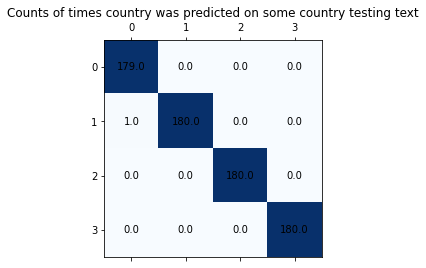

In [95]:
from collections import Counter
count_err_dict = Counter(list(zip(y_pred, y_test_)))
count_err_matrix = np.zeros((4, 4))
for k, val in count_err_dict.items():
    count_err_matrix[k[0]-1][k[1]-1] = val
    
draw_count_err_matrix(count_err_matrix)

### In the context of the matrix above numbers are such that:

In [375]:
{k: v-1 for k, v in dict_country_unique_num.items()}

{'usa': 0, 'china': 1, 'italy': 2, 'germany': 3}

### Feature importance

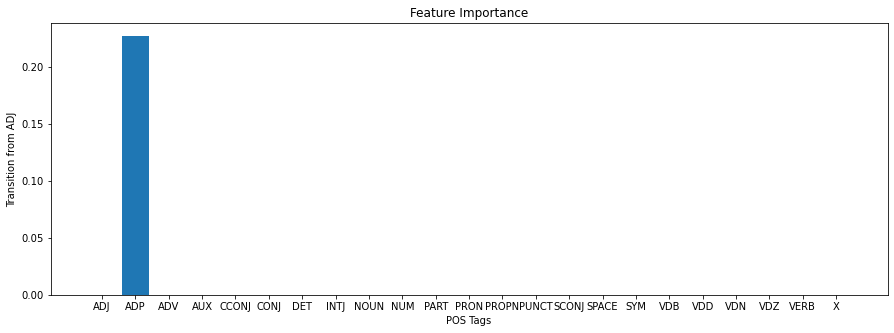

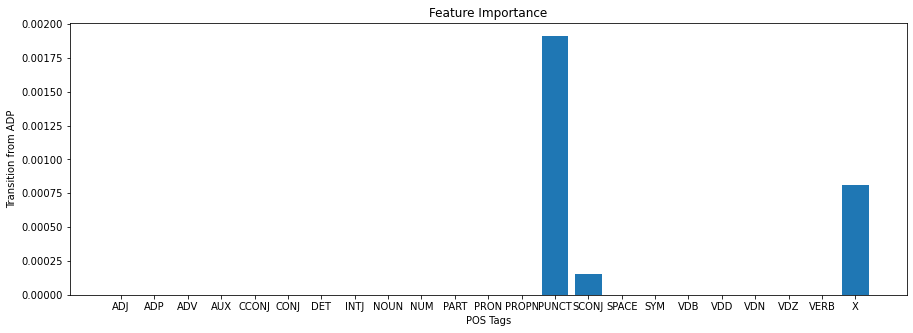

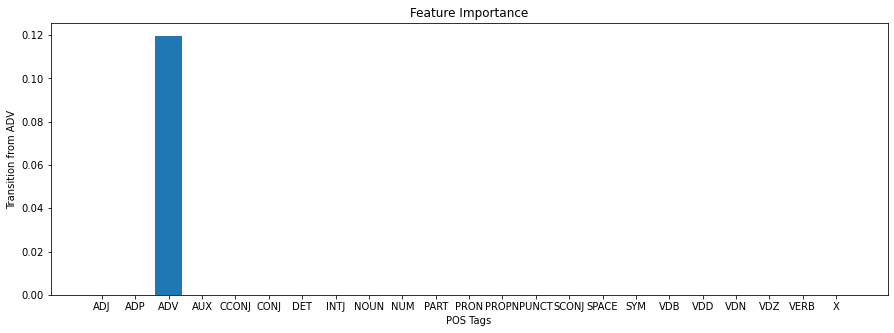

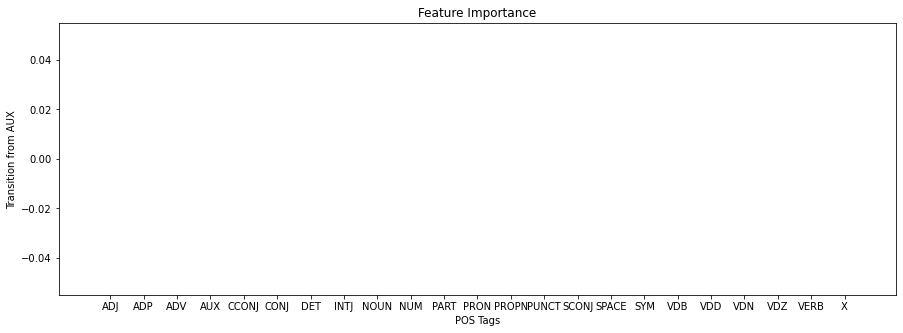

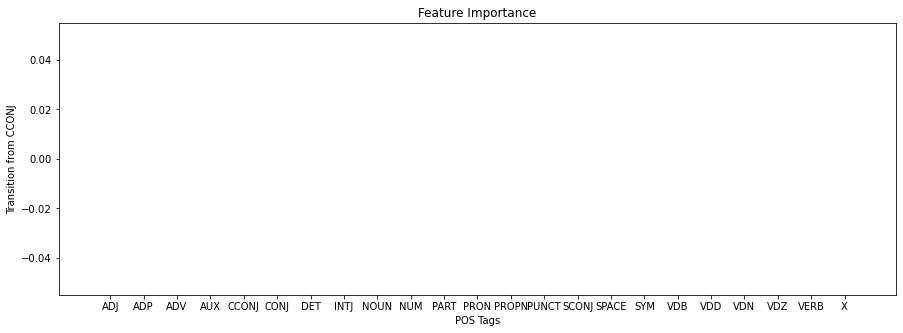

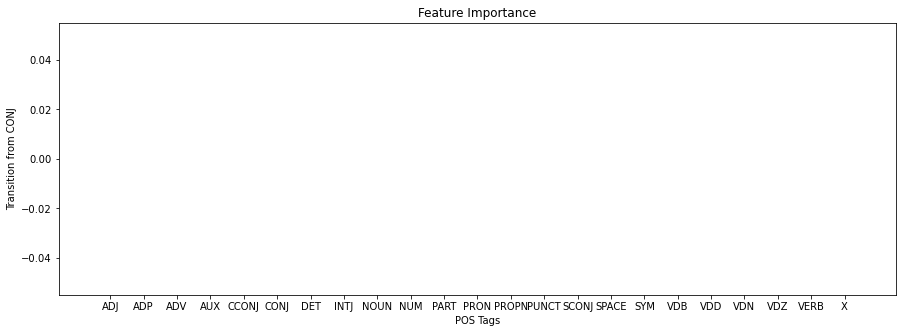

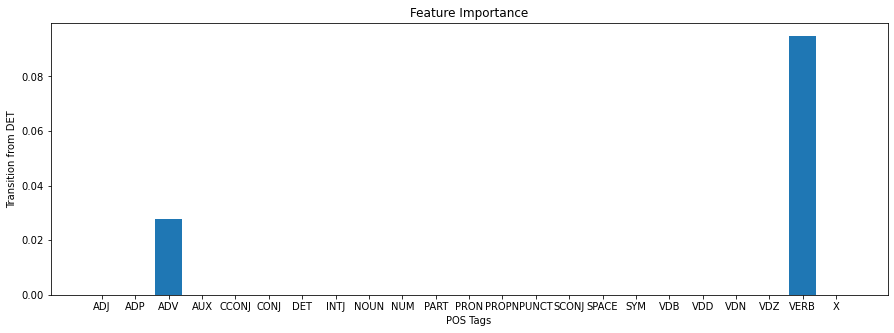

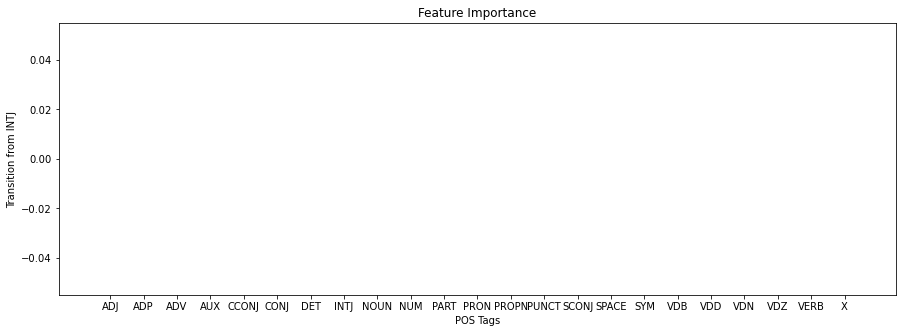

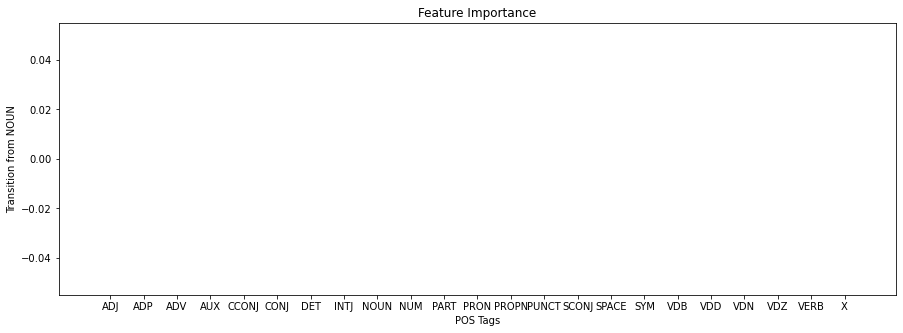

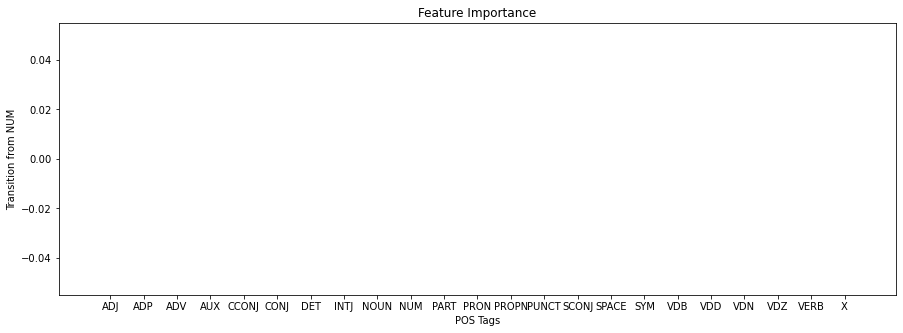

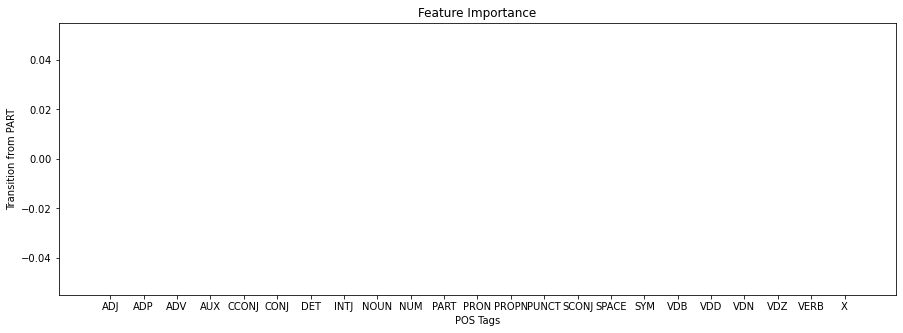

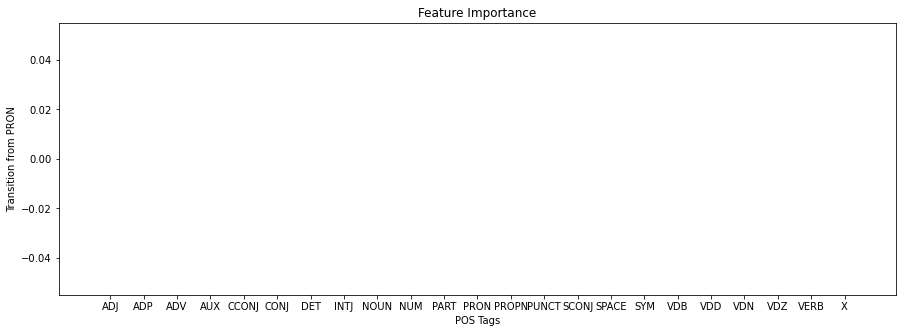

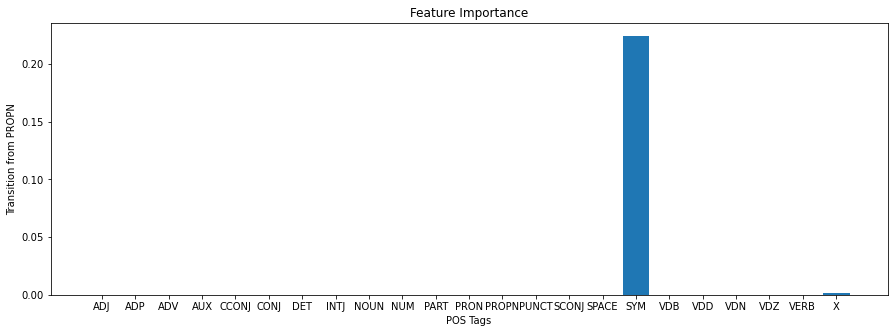

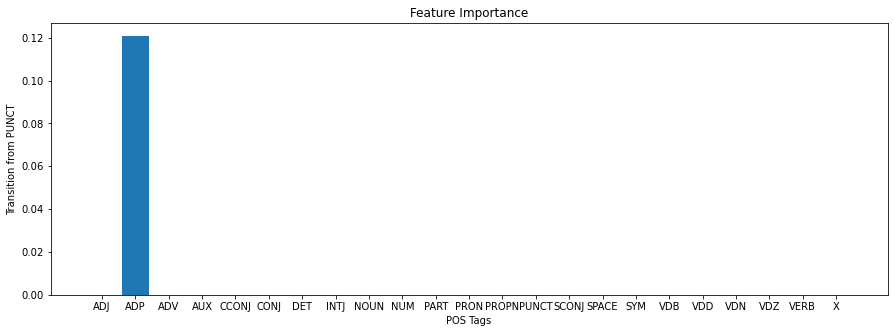

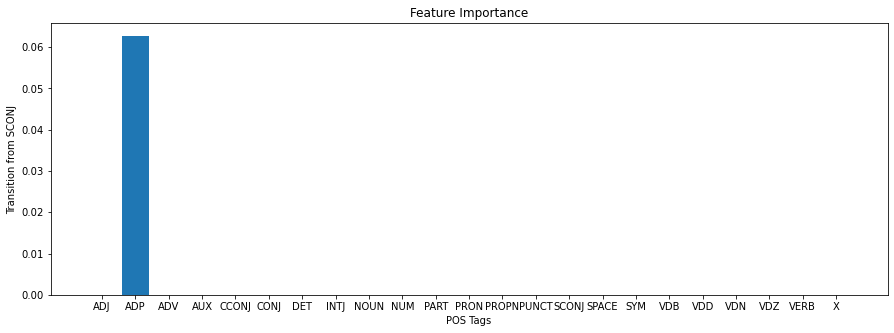

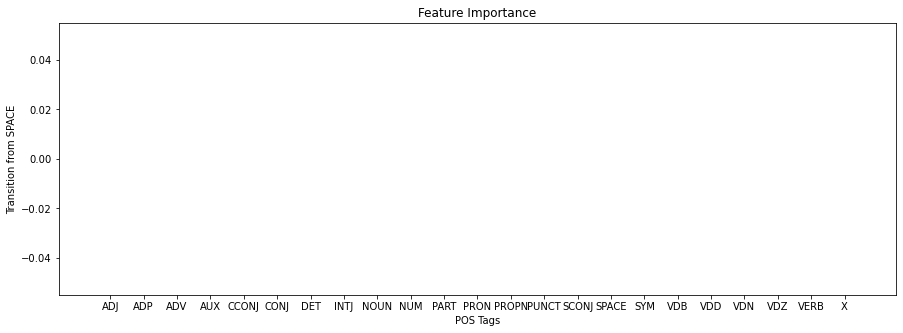

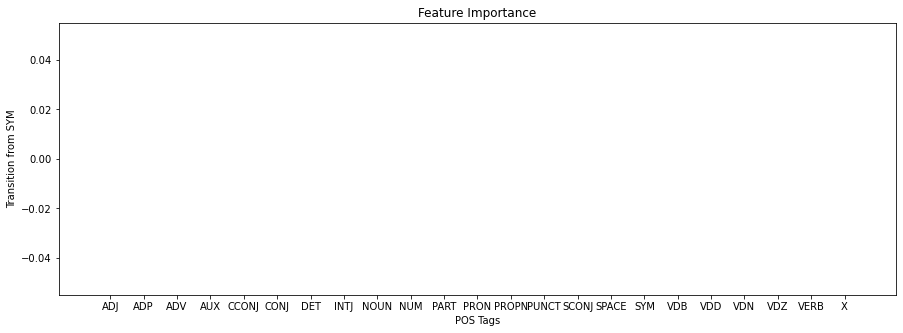

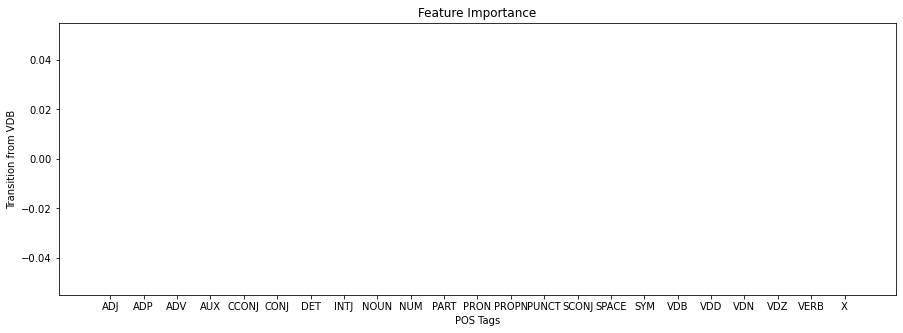

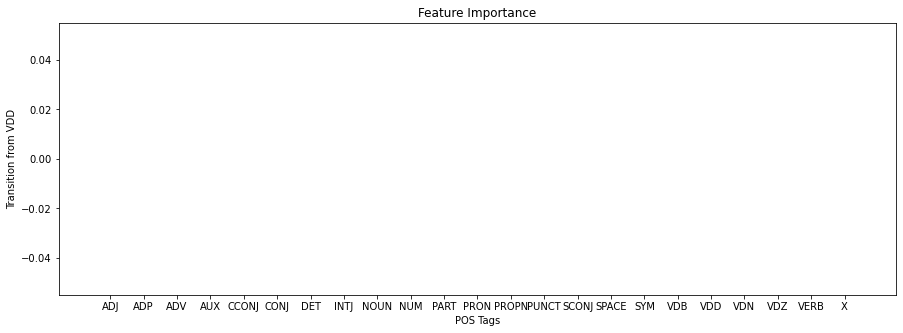

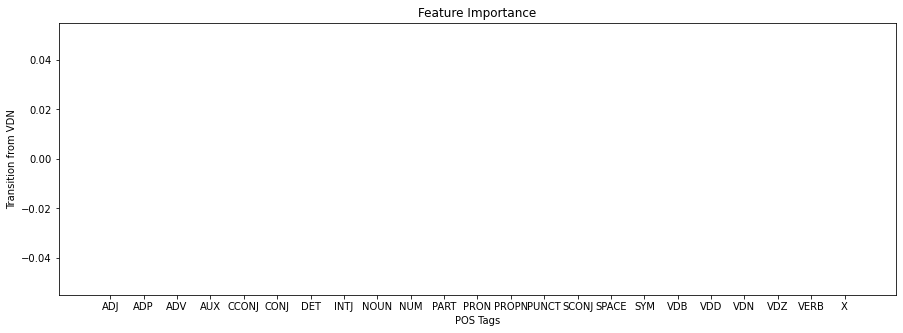

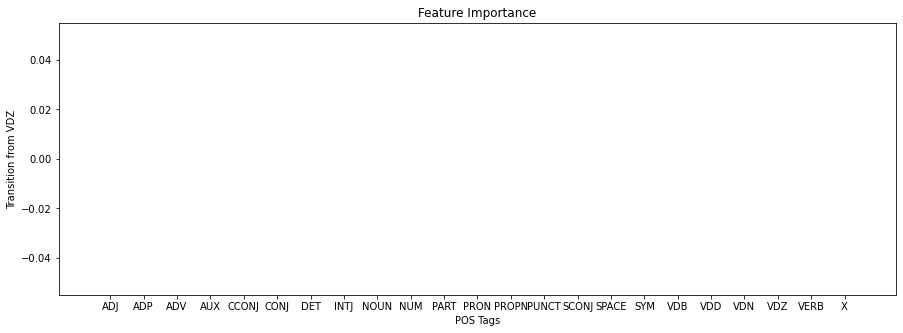

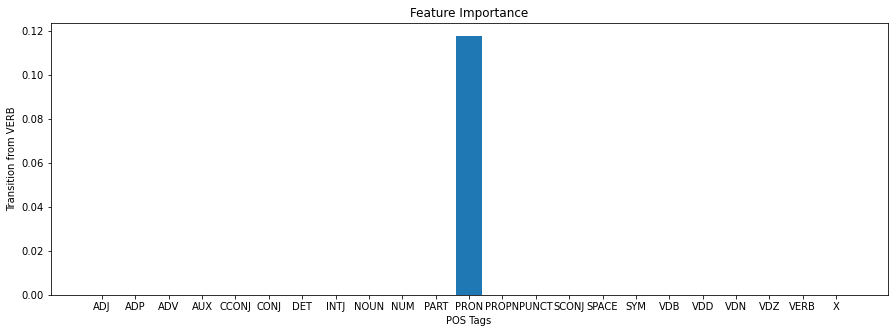

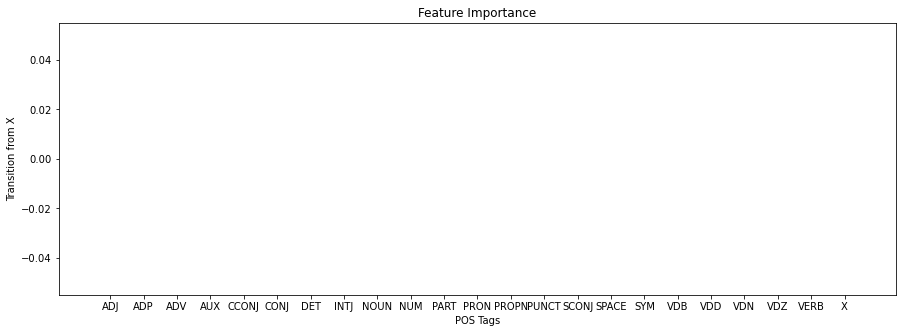

In [422]:
## pos_feature_importance_dict = {all_states[i]: feature for i, feature in enumerate(clf.feature_importances_)}
st = 0

for time in range(num_times):
    end = num_times + st
    
    # plot
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.bar(range(len(clf.feature_importances_[st:end])), clf.feature_importances_[st:end])
    ax.set_title('Feature Importance')
    labels = list(states)
    x = np.arange(len(labels))
    ax.set_xlabel('POS Tags')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel(f'Transition from {states[time]}')
    
    plt.show()
    st = end

```CPP
ambiguous word example: 
('ADJ', 'ADP') 32344
('DET', 'ADV') 928
```

In [216]:
pos_feature_importance_dict = {all_states[i]: feature for i, feature in enumerate(clf.feature_importances_)}
pos_feature_importance_dict
important_features = [k for k, v in pos_feature_importance_dict.items() if v > 0]

important_features_dict = {}
for k in important_features:
    important_features_dict[k] = pos_feature_importance_dict[k]
important_features_dict

{'ADJ_ADJ': 0.00026552854,
 'ADJ_ADP': 0.0002003592,
 'ADJ_X': 0.001811977,
 'ADP_PUNCT': 0.008702397,
 'DET_ADV': 0.10806122,
 'DET_PUNCT': 0.1582543,
 'DET_VERB': 0.30292737,
 'PROPN_X': 0.003122736,
 'PUNCT_ADP': 0.15540212,
 'SCONJ_ADP': 0.06903059,
 'VERB_CCONJ': 0.00024676108,
 'VERB_PRON': 0.19197461}

Alphabetical listing
* ADJ: adjective - прикметник
* ADP: adposition - прийменник
* ADV: adverb - прислівник
* AUX: auxiliary verb - типові дієслова (був, є)
* CONJ: coordinating conjunction - сполучник
* DET: determiner - детермінітив (which, that …)
* INTJ: interjection
* NOUN: noun
* NUM: numeral - 
* PART: particle
* PRON: pronoun
* PROPN: proper noun
* PUNCT: punctuation - 
* SCONJ: subordinating conjunction - підрядний сполучник (although, because, if, that)
* SYM: symbol
* VERB: verb
* X: other

In [6]:
path_to_model = "./data/pos_matrices_country/model/xgb_clf.pkl"

# save
# pickle.dump(clf, open(path_to_model, "wb"))

In [38]:
from main.helpers.transition_emission import create_dictionaries, create_transition_matrix, create_emission_matrix

PATH_TO_ORIGINAL_AB = './data/pos_matrices'
DIR_FULL_FILES = 'shuffled_data_pos_tags_matrices_full_article'
DIR_FULL_FILES2 = 'shuffled_data_pos_tags_matrices_full_article2'
VOCAB_COVID = os.path.join(PATH_TO_ORIGINAL_AB, 'vocab_covid.txt')
fixed_valid_train_files = {'usa': None, 'germany': None, 'italy': None, 'china': None}

### Show the result

### Load all the data

In [15]:
path_to_model = "./data/pos_matrices_country/model/xgb_clf.pkl"
# load
xgb_model_loaded = pickle.load(open(path_to_model, "rb"))

In [16]:
dict_country_unique_num = {'usa': 1, 'china': 2, 'italy': 3, 'germany': 4}

In [17]:
# Import A and B
A_df = pd.read_csv(os.path.join(PATH_TO_ORIGINAL_AB, 'A_df.csv'), index_col=0)
B_df = pd.read_csv(os.path.join(PATH_TO_ORIGINAL_AB, 'B_df.csv'), index_col=0)

In [18]:
A_shape = (23, 23)
B_shape = (23, 51935)
A = A_df.to_numpy()
B = B_df.to_numpy()
assert A.shape == A_shape, 'Wrong A shape'
assert B.shape == B_shape, 'Wrong B shape'

In [19]:
# Import vocab
f_vocab = open(VOCAB_COVID, 'r')
vocab = {el.replace('\n', ''): i for i, el in enumerate(f_vocab)}
f_vocab.close()

In [20]:
# Import tag_counts
f = open('./data/pos_matrices_country/tag_counts.json', 'r')
tag_counts = json.load(f)
f.close()

In [21]:
# Import states
states = list(A_df.index.values)
', '.join(states)

'ADJ, ADP, ADV, AUX, CCONJ, CONJ, DET, INTJ, NOUN, NUM, PART, PRON, PROPN, PUNCT, SCONJ, SPACE, SYM, VDB, VDD, VDN, VDZ, VERB, X'

In [22]:
def get_text_by_uid(cord_uid):
    return df_ready[df_ready['cord_uid'] == cord_uid].text.values[0]

def get_country_by_uid(cord_uid):
    return df_ready[df_ready['cord_uid'] == cord_uid].country.values[0].lower()

def check_if_all_the_states_in_tag_counts(states, tag_counts):
    for tag in states:
        if (tag_counts).get(tag, None) is None:
            tag_counts[tag] = 0
    return tag_counts

### Predict country by text

In [28]:
# create dictionary of files for train & test
fixed_valid_train_files = {'usa': None, 'germany': None, 'italy': None, 'china': None}
for k in fixed_valid_train_files.keys():
    fixed_valid_train_files[k] = {'train': [], 'test': []}

train_size_alpha = 0.8
# choose which files should go where
for country_name, country_path in country_path_dict.items():
    print(f'\nCountry {country_name}')
    cur_section = 'shuffled_data_pos_tags'
    tagged_data_path = os.path.join(country_path, cur_section)
    print('tagged_data_path = ', tagged_data_path, '; len = ', len(os.listdir(tagged_data_path)))
    
    lst_of_files = list(filter(lambda x: x != '', list(map(lambda x: x.split('.')[0], os.listdir(tagged_data_path)))))
    print(len(lst_of_files))
    len_of_train = int(len(lst_of_files) * train_size_alpha)
    print(len_of_train)
    len_of_test = len(lst_of_files) - len_of_train
    print(len_of_test)
    fixed_valid_train_files[country_name]['train'] = np.random.choice(lst_of_files, len_of_train, replace=False)
    fixed_valid_train_files[country_name]['test'] = np.array([x for x in lst_of_files \
                                                     if not x in fixed_valid_train_files[country_name]['train']])


Country usa
tagged_data_path =  ./data/pos_matrices_country/usa/shuffled_data_pos_tags ; len =  896
896
716
180

Country china
tagged_data_path =  ./data/pos_matrices_country/china/shuffled_data_pos_tags ; len =  896
896
716
180

Country italy
tagged_data_path =  ./data/pos_matrices_country/italy/shuffled_data_pos_tags ; len =  896
896
716
180

Country germany
tagged_data_path =  ./data/pos_matrices_country/germany/shuffled_data_pos_tags ; len =  897
896
716
180


In [29]:
lst = []
for country_name, country_path in country_path_dict.items():
    print('Country: ', country_name)
    path_to_AB = os.path.join(country_path, DIR_FULL_FILES)
    for file_name in fixed_valid_train_files[country_name]['test']:
        lst.append((file_name, country_name))
#         file_with_a_file_name = [file for file in os.listdir(path_to_AB) if file_name in file][0]
#         full_file_path = os.path.join(path_to_AB, file_with_a_file_name)
lst

Country:  usa
Country:  china
Country:  italy
Country:  germany


[('rdd99ct5', 'usa'),
 ('kjzkk51t', 'usa'),
 ('5x6af5jm', 'usa'),
 ('uazgbbd0', 'usa'),
 ('8vskbxy0', 'usa'),
 ('mdsjbfmx', 'usa'),
 ('1m071lab', 'usa'),
 ('blw261co', 'usa'),
 ('gnd78gqg', 'usa'),
 ('ovmko655', 'usa'),
 ('x96ilmp9', 'usa'),
 ('bupfw5la', 'usa'),
 ('qf8zun2v', 'usa'),
 ('d3gggwgk', 'usa'),
 ('cowt4c2c', 'usa'),
 ('vi2fb43t', 'usa'),
 ('c4cs14ja', 'usa'),
 ('pzs2810x', 'usa'),
 ('wvltfxkb', 'usa'),
 ('rzs5alfk', 'usa'),
 ('3b63v8ja', 'usa'),
 ('z514v0um', 'usa'),
 ('g844u7xg', 'usa'),
 ('jzzt8hoa', 'usa'),
 ('so0v8h54', 'usa'),
 ('0uhabgsr', 'usa'),
 ('3fsegyme', 'usa'),
 ('1ysn0kyr', 'usa'),
 ('2dfiwo65', 'usa'),
 ('uc6k03ge', 'usa'),
 ('c2zikoak', 'usa'),
 ('lx5zrl85', 'usa'),
 ('yzv43e8l', 'usa'),
 ('didoug6j', 'usa'),
 ('51b7oh8s', 'usa'),
 ('z2kudqeu', 'usa'),
 ('w0zqxwdh', 'usa'),
 ('xkx181ek', 'usa'),
 ('9dldbs6o', 'usa'),
 ('zv4nbz9p', 'usa'),
 ('8gp9mjen', 'usa'),
 ('uynd63m5', 'usa'),
 ('49efokw2', 'usa'),
 ('wnmd0t1t', 'usa'),
 ('sbr0aq3s', 'usa'),
 ('fsesvyg

In [33]:
df_ready = pd.read_csv('./data/paper_country_the_biggest.csv')

def custom_split(text):
    return list(filter(lambda x: not(x == '' or x == ' '), re.split(r'(\b[^\s]+\b)', text.strip())))

In [38]:
num_times = int(529/len(states))
all_states = []
for time in range(num_times):
    all_states += list(map(lambda x: states[time] + '_' + x, states))


In [39]:
# cord_uid = 'dvuxuf3q'
# cord_uid = 'stba2epw'
# cord_uid = 'ibnudp1x'
cord_uid = 'a2cyr3at'
# cord_uid = '56h2jmn9'
# cord_uid = 'jjh24ipb'
# cord_uid = '3wvl71cj'

article_of_uid = get_text_by_uid(cord_uid)
labled_country_of_uid = get_country_by_uid(cord_uid)

text_words = custom_split(article_of_uid)
orig, prep_text = get_prep(text_words, vocab)

print(len(prep_text))
best_probs, best_paths = initialize(states, tag_counts, A, B, prep_text, vocab)
best_probs, best_paths = viterbi_forward(A, B, prep_text, best_probs, best_paths, vocab)

pred_text = viterbi_backward(best_probs, best_paths, prep_text, states)

assert len(prep_text) == len(pred_text), 'Prep text and Pred tags are different in length'

corpus_l = []
for i in range(len(prep_text)):
    word, tag = prep_text[i], pred_text[i]
    corpus_l.append(word + '\t' + tag + '\n')

emission_counts, transition_counts, tag_counts = create_dictionaries(corpus_l, vocab)
article_tag_counts = check_if_all_the_states_in_tag_counts(states, tag_counts)

alpha = 0.001
article_A = create_transition_matrix(alpha, article_tag_counts, transition_counts)
flat_article_A = article_A.flatten()


df_A = pd.DataFrame.from_records([flat_article_A,])
df_A.columns = all_states
df_A.head()

9854
Words processed:     5000


ADJ_ADJ   ADJ_ADP  ADJ_ADV   ADJ_AUX  ADJ_CCONJ  ADJ_CONJ  ADJ_DET  \
0  0.062827  0.073298  0.00131  0.000001   0.017017  0.000001  0.00131   

   ADJ_INTJ  ADJ_NOUN   ADJ_NUM  ...   X_PUNCT   X_SCONJ   X_SPACE     X_SYM  \
0  0.000001  0.766994  0.000001  ...  0.992722  0.000331  0.000331  0.000331   

      X_VDB     X_VDD     X_VDN     X_VDZ    X_VERB       X_X  
0  0.000331  0.000331  0.000331  0.000331  0.000331  0.000331  

[1 rows x 529 columns]

In [40]:
df_ready[df_ready['cord_uid'] == cord_uid]

cord_uid      source_x  \
2047  a2cyr3at  Medline; PMC   

                                                  title publish_time  \
2047  Photonic Crystal Nanobeam Cavities for Nanosca...   2020-01-09   

                                                authors  \
2047  Yang, Da-Quan; Duan, Bing; Liu, Xiao; Wang, Ai...   

                                         pdf_json_files  \
2047  document_parses/pdf_json/1a7d600387654c0315c07...   

                    journal  \
2047  Micromachines (Basel)   

                                                   text  \
2047  Ultra-sensitive and rapid detection of nanosca...   

                                            institution  \
2047  Beijing University of Posts and Telecommunicat...   

                                             laboratory country  
2047  Beijing University of Posts and Telecommunicat...   China

In [41]:
y_pred_for_uid_text = xgb_model_loaded.predict(df_A.to_numpy())[0]
pred_country = [k for k, v in dict_country_unique_num.items() if v == y_pred_for_uid_text][0]

print('Labled: ', labled_country_of_uid)
print('Predicted: ', pred_country)
print(orig[:10])

Labled:  china
Predicted:  china
['ultra-sensitive', 'and', 'rapid', 'detection', 'of', 'nanoscale', 'analytes', 'plays', 'an', 'important']


#### List of all text uid and their country

In [491]:
uid_country_list_more_5000 = []
for row in df_ready.iterrows():
    row_series = list(row[1])
    text_len = len(custom_split(row_series[-4]))
    if text_len <= 5000:
        continue
    uid = row_series[0]
    country_of_uid = row_series[-1].lower()
    uid_country_list_more_5000.append((uid, country_of_uid))
uid_country_list_more_5000

[('6dq8xx7c', 'usa'),
 ('g3k1lpvd', 'germany'),
 ('d1w4rbze', 'italy'),
 ('c4cs14ja', 'usa'),
 ('fkjwsr5p', 'china'),
 ('82drb14x', 'china'),
 ('pta3nzz9', 'usa'),
 ('ad3tnj4f', 'china'),
 ('1w5pmdix', 'germany'),
 ('s75epoxf', 'italy'),
 ('w2sb6h94', 'usa'),
 ('hlyk7qws', 'usa'),
 ('lgprrwee', 'germany'),
 ('i3jslrae', 'italy'),
 ('nz05fzac', 'italy'),
 ('wyz5jyjh', 'china'),
 ('ubazgvov', 'italy'),
 ('zy3au017', 'usa'),
 ('hn6f6mzh', 'germany'),
 ('7m2shx8g', 'usa'),
 ('4mdu4g9v', 'italy'),
 ('ttnzg1hn', 'italy'),
 ('pfrpbvtt', 'italy'),
 ('wtp5e41n', 'germany'),
 ('46jdhm1o', 'germany'),
 ('yocvwvbd', 'usa'),
 ('rlb7ozaz', 'usa'),
 ('x02chc60', 'usa'),
 ('a2ys828w', 'italy'),
 ('ckswlo9o', 'usa'),
 ('7h33bode', 'italy'),
 ('qh98622y', 'china'),
 ('5ekrx57a', 'germany'),
 ('8flsy5o1', 'china'),
 ('8nnobx8g', 'germany'),
 ('h7enr0op', 'italy'),
 ('oyxkzzs8', 'china'),
 ('yl0xbebp', 'germany'),
 ('3wzlaytc', 'china'),
 ('4g30jeif', 'china'),
 ('6r6qs4pp', 'italy'),
 ('7omfhts1', 'italy

In [492]:
len(uid_country_list_more_5000)

1243

#### List of the articles of size < 5000

In [400]:
uid_country_list_less_5000 = []
for row in df_ready.iterrows():
    row_series = list(row[1])
    text_len = len(custom_split(row_series[-4]))
    if text_len > 5000:
        continue
    uid = row_series[0]
    country_of_uid = row_series[-1].lower()
    uid_country_list_less_5000.append((uid, country_of_uid))
uid_country_list_less_5000

[('stsvjqhu', 'italy'),
 ('3sl5u35h', 'italy'),
 ('gx6qy28p', 'usa'),
 ('0m8sicqn', 'italy'),
 ('te049lxh', 'usa'),
 ('e27lm7rr', 'italy'),
 ('cthgz65m', 'italy'),
 ('4a47bdy0', 'italy'),
 ('0azjh2dy', 'usa'),
 ('d5u6n939', 'usa'),
 ('57qa23om', 'china'),
 ('ebo78pd3', 'usa'),
 ('gj0jofdb', 'usa'),
 ('6n241ccp', 'china'),
 ('51b7oh8s', 'usa'),
 ('k9xhphpl', 'germany'),
 ('v5hrcl5k', 'usa'),
 ('c6mgosdo', 'china'),
 ('3wgu52rq', 'usa'),
 ('wzrals6m', 'italy'),
 ('h13v8i14', 'china'),
 ('whvq8y1p', 'italy'),
 ('46ywjqrj', 'germany'),
 ('ek27vihk', 'china'),
 ('d049rh86', 'china'),
 ('2gs1scbv', 'usa'),
 ('ahh8or3o', 'usa'),
 ('n97hy2rc', 'italy'),
 ('bfqsyiyf', 'germany'),
 ('84hxta9d', 'italy'),
 ('pzgy2zem', 'usa'),
 ('oq9r3k6f', 'italy'),
 ('juooj31c', 'china'),
 ('l0xginsa', 'italy'),
 ('auo7urg3', 'usa'),
 ('2anqedib', 'italy'),
 ('4cdoeuf0', 'italy'),
 ('q8opsa8p', 'china'),
 ('jjt5nnsv', 'italy'),
 ('n8wn4och', 'china'),
 ('gwvf61hm', 'usa'),
 ('xeva9ovn', 'usa'),
 ('nzvuugls', 'c

In [493]:
len(uid_country_list_less_5000)

4584

### Test data articles > or < 5000:

In [494]:
for el in uid_country_list_less_5000:
    if el in lst:
        print(el)

('stsvjqhu', 'italy')
('6n241ccp', 'china')
('ek27vihk', 'china')
('2gs1scbv', 'usa')
('ahh8or3o', 'usa')
('2anqedib', 'italy')
('hrowa62z', 'italy')
('3za5awfq', 'china')
('tj7iq4bj', 'germany')
('fkw8780t', 'china')
('kzudasop', 'china')
('sy3n8v7f', 'germany')
('ckony02h', 'germany')
('kuh3t245', 'china')
('2l7veb7w', 'usa')
('iomk99lv', 'germany')
('hrmbg0an', 'italy')
('obmyd670', 'china')
('1kul8sbe', 'italy')
('j2twalcx', 'italy')
('kueqo67y', 'china')
('v034aa1m', 'china')
('duie9zp9', 'germany')
('6r1uhdom', 'usa')
('d0mgma42', 'china')
('bu2w2ox6', 'china')
('db67d88e', 'china')
('ablp9jh8', 'usa')
('w7h5317w', 'china')
('stba2epw', 'italy')
('ux32cmsg', 'italy')
('u4ey9dc7', 'germany')
('0evw0fc5', 'usa')
('zq1pso8a', 'usa')
('8ydgzcn0', 'germany')
('1wbh01ak', 'china')
('2ra85537', 'italy')
('kfhpbz8q', 'italy')
('6knskl5l', 'italy')
('ruxz77i8', 'usa')
('ip912edx', 'usa')
('z7i8ldlz', 'usa')
('tl43jaa0', 'china')
('tgaqtnpz', 'italy')
('ueeu3yip', 'italy')
('c2zikoak', 'us

In [495]:
for el in uid_country_list_more_5000:
    if el in lst:
        print(el)

('ad3tnj4f', 'china')
('1w5pmdix', 'germany')
('w2sb6h94', 'usa')
('lgprrwee', 'germany')
('a2ys828w', 'italy')
('qh98622y', 'china')
('yl0xbebp', 'germany')
('7omfhts1', 'italy')
('ehmd6tvi', 'germany')
('jl3vnpbi', 'germany')
('t98n1nh1', 'germany')
('gnn9lh56', 'italy')
('7y1la856', 'italy')
('x0lk4110', 'italy')
('i9oiahy3', 'usa')
('uih4jf8w', 'usa')
('o111pf7z', 'italy')
('h8ykn6ut', 'usa')
('gq6k0f3q', 'germany')
('vioymdp0', 'china')
('fi7dxrmr', 'china')
('du3tyqrp', 'china')
('jtaz1gdp', 'china')
('za3d2chm', 'usa')
('7se14455', 'italy')
('hzy3cti8', 'china')
('4g6036po', 'germany')
('8igfuaw2', 'usa')
('0szqd6bj', 'germany')
('32zroj99', 'usa')
('cgsh783e', 'usa')
('iw4xxkfr', 'usa')
('jpespecj', 'germany')
('t22pzqvu', 'italy')
('49rm7pmw', 'italy')
('hvwa95hz', 'italy')
('vy0yngoy', 'usa')
('judp4703', 'usa')
('wj481e51', 'usa')
('7cjm2yp0', 'germany')
('1vrhfc3k', 'italy')
('mipj57ze', 'china')
('sbr0aq3s', 'usa')
('o7zpbpvs', 'usa')
('rdldvnc0', 'usa')
('3bpcf28i', 'germ

In [221]:
df_ready.head()

cord_uid                source_x  \
1524  stsvjqhu  Elsevier; Medline; PMC   
1680  3sl5u35h  Elsevier; Medline; PMC   
3949  6dq8xx7c  Elsevier; Medline; PMC   
1155  g3k1lpvd                     PMC   
2571  gx6qy28p  Elsevier; Medline; PMC   

                                                  title publish_time  \
1524  In the search of potential epitopes for Wuhan ...   2020-04-23   
1680  Letter to the Editor on “Bonafè M, Prattichizz...   2020-06-04   
3949  Recent progress and challenges in drug develop...   2020-04-19   
1155  Estimating Characteristic Sets for RDF Dataset...   2020-05-07   
2571  An Outlook on the Global Development of Renewa...   2020-06-01   

                                                authors  \
1524                   Santoni, Daniele; Vergni, Davide   
1680  Quiros-Roldan, Eugenia; Biasiotto, Giorgio; Za...   
3949     El-Aziz, Tarek Mohamed Abd; Stockand, James D.   
1155                      Heling, Lars; Acosta, Maribel   
2571                              Ehsan Hosseini, Seyed   

                                         pdf_json_files  \
1524  document_parses/pdf_json/33e08133713a66c7df2c4...   
1680  document_parses/pdf_json/5953e4cee71a72714880d...   
3949  document_parses/pdf_json/0ddffb5065201f469bdbc...   
1155  document_parses/pdf_json/5181d7bb2ce6a5a3ae079...   
2571  document_parses/pdf_json/f81efa75ab4077e836052...   

                         journal  \
1524           J Immunol Methods   
1680  Cytokine Growth Factor Rev   
3949           Infect Genet Evol   
1155            The Semantic Web   
2571          Energy Res Soc Sci   

                                                   text  \
1524  Coronaviruses belong to the family of Coronavi...   
1680  This is a PDF file of an article that has unde...   
3949  In the second week of December 2019, unknown v...   
1155  The characteristics of an RDF dataset can be f...   
2571  renewable and sustainable energy systems will ...   

                                            institution  \
1524                 National Research Council of Italy   
1680                              University of Brescia   
3949  University of Texas Health Science Center at S...   
1155            Karlsruhe Institute of Technology (KIT)   
2571                           Arkansas Tech University   

                                             laboratory  country  
1524                 National Research Council of Italy    Italy  
1680                              University of Brescia    Italy  
3949  University of Texas Health Science Center at S...      USA  
1155            Karlsruhe Institute of Technology (KIT)  Germany  
2571                           Arkansas Tech University      USA

In [224]:
df_ready[df_ready['cord_uid'] == 'ykiy3swo']

cord_uid      source_x  \
846  ykiy3swo  Medline; PMC   

                                                 title publish_time  \
846  Coronavirus disease (COVID-19): observations a...   2020-05-21   

                                               authors  \
846  Schiller, Martin; Fisahn, Juergen; Huebner, Ut...   

                                        pdf_json_files  \
846  document_parses/pdf_json/b8c871f65148d16a4da64...   

                                               journal  \
846  Journal of community hospital internal medicin...   

                                                  text           institution  \
846  COVID-19 is a novel disease caused by the SARS...  Kliniken Hochfranken   

               laboratory  country  
846  Kliniken Hochfranken  Germany

In [260]:
for i, file in enumerate(fixed_valid_train_files[country_name]['test']):
    print('Filename: ', file)
    file_data = df_ready[df_ready['cord_uid'] == file]
    num_of_country = y_pred[i]
    country = [k for k, v in dict_country_unique_num.items() if v == num_of_country][0]
    print(country, '\n', file_data.text)

Filename:  ykiy3swo
usa 
 846    COVID-19 is a novel disease caused by the SARS...
Name: text, dtype: object
Filename:  my8ow5ee
usa 
 2347    Orthomyxoviridae's major representatives are t...
Name: text, dtype: object
Filename:  a233g9ba
usa 
 1151    In 2009, Staworko and Niehren observed that eq...
Name: text, dtype: object
Filename:  3jkqpczc
usa 
 194    Dear Readers, "The ball is round, and a game l...
Name: text, dtype: object
Filename:  a0dqy0sz
usa 
 5795    2 Dear Sirs, Accumulating evidence indicates a...
Name: text, dtype: object
Filename:  l70slh01
usa 
 628    To appear in: ResuscitationIn 2017, the surviv...
Name: text, dtype: object
Filename:  a9vogy9b
usa 
 5708    The European government debt crisis has shown ...
Name: text, dtype: object
Filename:  o9icinur
usa 
 1262    A previously unknown coronavirus, the severe a...
Name: text, dtype: object
Filename:  pkxktpy5
usa 
 1693    As far as we know today, bacterial lipoprotein...
Name: text, dtype: object
Filename:  gm

usa 
 901    The core functionality of the tool Cycl n is t...
Name: text, dtype: object
Filename:  rq9hmjsx
usa 
 6    The current outbreak of a novel coronavirus 20...
Name: text, dtype: object
Filename:  jl3vnpbi
usa 
 696    On 27 January 2020, the first case of coronavi...
Name: text, dtype: object
Filename:  e3nqcelh
usa 
 2019    Telemedicine, a term coined in the 1970s, lite...
Name: text, dtype: object
Filename:  xlh1wm19
usa 
 1870    The use of urban open spaces is essential. Thi...
Name: text, dtype: object
Filename:  6vweg7lf
usa 
 10    For today's computational requirements of the ...
Name: text, dtype: object
Filename:  m4too6ob
usa 
 1943    seasons. On the other hand, they presented the...
Name: text, dtype: object
Filename:  gq6k0f3q
usa 
 68    Viruses occupy a unique position at the bounda...
Name: text, dtype: object
Filename:  dvuxuf3q
usa 
 850    well as ameliorating morbidity and mortality i...
Name: text, dtype: object
Filename:  q55g7fz9
usa 
 1457    A nove

In [ ]:
# TODO: spaCy 


### SpaCy Dep

In [412]:
# ! pip install spacy
import spacy

ImportError: cannot import name util

In [413]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(u"displaCy uses JavaScript, SVG and CSS.")
# spacy.displacy.serve(doc, style='dep')

for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

NameError: name 'spacy' is not defined